# Telecom Data Cup (Mlbootcamp)
<span style="font-size:0.6em;">I'm really sorry for the quality of my code, I swear I code beter in production.</span>

First of all, I tried Azure Auto ml and auto sklearn on preprocessed data but they did not produce any acceptable results. As I tried them on Azure I did not include its code into this notebook.

In [6]:
import dask.dataframe as dd
import os
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV

from hyperopt import hp, tpe
from hyperopt.fmin import fmin

from pandas_profiling import ProfileReport

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer, FunctionTransformer

from sklearn.model_selection import train_test_split

import lightgbm

from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer

from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold, TimeSeriesSplit, cross_val_score

from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.metrics import roc_auc_score

from feature_selector import FeatureSelector

from catboost import CatBoostClassifier

from sklearn.linear_model import ElasticNet
from sklearn.svm import SVC

from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score

from mlens.ensemble import SuperLearner, BlendEnsemble
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import category_encoders as ce

from mlens.ensemble import Subsemble

from mlens.preprocessing import Subset

%matplotlib inline

[MLENS] backend: threading


# Joining data
I needed to join big datatable with the info about cells with small tables containing info about other features. The easiest way I've found to do is to rent some Ubuntu VM on Azure with 64GB of RAM, use Dask to import this big datatable efficiently and just persist it in RAM for quick operations.  
(BTW: How to deal with such data without using big RAM, Dask or Spark?)


In [5]:
from dask.distributed import Client, progress
client = Client(n_workers=8, threads_per_worker=2, memory_limit='8GB')
client

<Client: scheduler='tcp://127.0.0.1:36619' processes=8 cores=16>

We have two types of problems: bad voice connections and bad internet. That is why for every user we need to join info for at least two cells - the cell he uses the most for calls and the cell he uses the most for the internet.
I do not have enough computing power to join with any cell every user uses and joining with only two or three cells rather than one didn't much affect the final result.

In [7]:
def extract_cell(df, column_name, column_to_rename):
    grouped = df.groupby(by=["SK_ID", "CELL_LAC_ID"], as_index=False).sum()   
    sorted = grouped.sort_values(by=["SK_ID", column_name], ascending=[True, False])
    most_used = sorted.groupby("SK_ID", as_index=False).head(1)
    most_used = most_used[["SK_ID", "CELL_LAC_ID"]]
    most_used = most_used.rename(index=str, columns={"CELL_LAC_ID" : column_to_rename})
    return most_used

In [8]:
def bigTablePreprocess(trainOrTest="train"):
    df = dd.read_csv('train/bs_avg_kpi.csv', sep=";", decimal=',')
    #I use the simplest way - just get mean info about every cell from all dates
    df = df.groupby(by="CELL_LAC_ID").mean()

    df = df.persist()
    #I drop empty or useless columns
    df = df.drop(['UTIL_BRD_CPU_3G', 'T_DATE', 'UTIL_CE_DL_3G', 'UTIL_CE_HW_DL_3G', 'UTIL_CE_UL_3G', 'UTIL_SUBUNITS_3G', 'UL_VOLUME_LTE', 'DL_VOLUME_LTE', 'RTWP_3G', 'RBU_AVAIL_DL_LTE', 'PROC_LOAD_3G', 'HSPDSCH_CODE_UTIL_3G', 'NODEB_CNBAP_LOAD_HARDWARE'], axis=1)

    csi = pd.read_csv(trainOrTest + "/subs_csi_"+ trainOrTest + ".csv")
    consumption = pd.read_csv(trainOrTest + "/subs_bs_consumption_" + trainOrTest + ".csv")

    voice = extract_cell(consumption, "SUM_MINUTES", "MOST_VOICE_CELL_ID")

    internet = extract_cell(consumption, "SUM_DATA_MIN", "MOST_INTERNET_CELL_ID")

    most_used = voice.merge(internet, on="SK_ID")

    trafic = consumption.groupby(by=["SK_ID"], as_index=False).sum() 

    trafic = trafic.drop(columns=['CELL_LAC_ID'])

    merged = most_used.merge(trafic, on="SK_ID")


    train = merged.merge(csi, on="SK_ID").drop(columns=['CONTACT_DATE'])
    
    # here and below I use Dask so I need to call compute for any operation to complete
    dd_train = dd.from_pandas(train, npartitions=3)
    
    res = dd_train.merge(df, left_on="MOST_VOICE_CELL_ID", right_on="CELL_LAC_ID", how="left").compute()

    res1 = dd_train.merge(df, left_on="MOST_INTERNET_CELL_ID", right_on="CELL_LAC_ID", how="left").compute()
    
    #I save results into csv for not doing this operation every time
    res.to_csv("voice_" + trainOrTest + ".csv", index=False)
    
    res1.to_csv("internet_" + trainOrTest + ".csv", index=False)

In [9]:
#bigTablePreprocess("train"):
#bigTablePreprocess("test"):

As a result of previous operation, we have two dataframes for each user - for voices and for the internet. Now we need to unite them into one. The main problem is that we need same columns but for separate cells (one bunch of columns about voice cell and other for internet cell)

In [10]:
common_columns_init = [
       'SK_ID'
]

voice_columns_init = [
       'SUM_MINUTES',
       'CELL_AVAILABILITY_2G', 'CELL_AVAILABILITY_3G', 'CELL_AVAILABILITY_4G',
       'CSSR_2G', 'CSSR_3G', 'ERAB_PS_BLOCKING_RATE_LTE',
       'RAB_CS_BLOCKING_RATE_3G', 'RAB_CS_DROP_RATE_3G',
       'RBU_AVAIL_DL',
       'RBU_AVAIL_UL', 'RBU_OTHER_DL', 'RBU_OTHER_UL', 'RBU_OWN_DL',
       'RBU_OWN_UL', 'RRC_BLOCKING_RATE_3G', 
       'SHO_FACTOR', 'TCH_DROP_RATE_2G'
]

internet_columns_init = [
       'SUM_DATA_MB', 
       'SUM_DATA_MIN',
       'CELL_AVAILABILITY_2G', 'CELL_AVAILABILITY_3G', 'CELL_AVAILABILITY_4G',
       'ERAB_PS_BLOCKING_RATE_LTE',
       'ERAB_PS_BLOCKING_RATE_PLMN_LTE', 'ERAB_PS_DROP_RATE_LTE',
       'PART_CQI_QPSK_LTE', 'PART_MCS_QPSK_LTE', 'PSSR_2G', 'PSSR_3G',
       'PSSR_LTE', 'RAB_CS_BLOCKING_RATE_3G', 'RAB_PS_DROP_RATE_3G', 'RBU_AVAIL_DL',
       'RBU_AVAIL_UL', 'RBU_OTHER_DL', 'RBU_OTHER_UL', 'RBU_OWN_DL',
       'RBU_OWN_UL', 'RRC_BLOCKING_RATE_3G', 'RRC_BLOCKING_RATE_LTE',
       'SHO_FACTOR', 'TBF_DROP_RATE_2G', 
       'TOTAL_DL_VOLUME_3G', 'TOTAL_UL_VOLUME_3G'
]

In [12]:
voice_bigtable = pd.read_csv("voice_train.csv", usecols=(common_columns_init + voice_columns_init))
internet_bigtable = pd.read_csv("internet_train.csv", usecols=(common_columns_init + internet_columns_init))

internet_bigtable = internet_bigtable.rename(columns={c : 'INTERNET_' + c for c in internet_columns_init})
voice_bigtable = voice_bigtable.rename(columns={c : 'VOICE_' + c for c in voice_columns_init})

consumption = voice_bigtable.merge(internet_bigtable, on="SK_ID")

subs_features = pd.read_csv('train/subs_features_train.csv', index_col='SK_ID')

features = sortByDate(subs_features, validateSet=True)

df = consumption.merge(features, on="SK_ID")
csi = pd.read_csv("train/subs_csi_train.csv")

df = df.merge(csi, on="SK_ID").drop(columns=['CONTACT_DATE'])

In result we have the dataframe with the following columns:

In [13]:
print(*df.columns, sep='\n')

SK_ID
VOICE_SUM_MINUTES
VOICE_CELL_AVAILABILITY_2G
VOICE_CELL_AVAILABILITY_3G
VOICE_CELL_AVAILABILITY_4G
VOICE_CSSR_2G
VOICE_CSSR_3G
VOICE_ERAB_PS_BLOCKING_RATE_LTE
VOICE_RAB_CS_BLOCKING_RATE_3G
VOICE_RAB_CS_DROP_RATE_3G
VOICE_RBU_AVAIL_DL
VOICE_RBU_AVAIL_UL
VOICE_RBU_OTHER_DL
VOICE_RBU_OTHER_UL
VOICE_RBU_OWN_DL
VOICE_RBU_OWN_UL
VOICE_RRC_BLOCKING_RATE_3G
VOICE_SHO_FACTOR
VOICE_TCH_DROP_RATE_2G
INTERNET_SUM_DATA_MB
INTERNET_SUM_DATA_MIN
INTERNET_CELL_AVAILABILITY_2G
INTERNET_CELL_AVAILABILITY_3G
INTERNET_CELL_AVAILABILITY_4G
INTERNET_ERAB_PS_BLOCKING_RATE_LTE
INTERNET_ERAB_PS_BLOCKING_RATE_PLMN_LTE
INTERNET_ERAB_PS_DROP_RATE_LTE
INTERNET_PART_CQI_QPSK_LTE
INTERNET_PART_MCS_QPSK_LTE
INTERNET_PSSR_2G
INTERNET_PSSR_3G
INTERNET_PSSR_LTE
INTERNET_RAB_CS_BLOCKING_RATE_3G
INTERNET_RAB_PS_DROP_RATE_3G
INTERNET_RBU_AVAIL_DL
INTERNET_RBU_AVAIL_UL
INTERNET_RBU_OTHER_DL
INTERNET_RBU_OTHER_UL
INTERNET_RBU_OWN_DL
INTERNET_RBU_OWN_UL
INTERNET_RRC_BLOCKING_RATE_3G
INTERNET_RRC_BLOCKING_RATE_LTE
INTERN

We get most recent features for each users and remove some more columns

In [1]:
def sortByDate(df, group=False):
    df['SNAP_DATE'] = pd.to_datetime(df['SNAP_DATE'], format='%d.%m.%y')
    df['BASE_TYPE'] -= 1
    if group:
        df = df.groupby(by="SK_ID", group_keys=False).apply(lambda grp: grp.nlargest(1, 'SNAP_DATE'))
    return df

In [14]:
df = sortByDate(df, True)
df = df.set_index('SK_ID')

X, y = df.drop(columns=["CSI", "SNAP_DATE", 'COM_CAT#24', 'ACT']), df["CSI"]

# EDA

For start analysis I used pandas-profiler

In [15]:
profileReport = ProfileReport(df)
profileReport

We see that we have 21 rejected variables, lots with zeros etc. But there is no highly correlated features with CSI neither in Spearman nor Pearson. Let's find out which features are categorical or binary. We can easily do it with this report and describe table

In [16]:
categorical_features = ['ARPU_GROUP','DEVICE_TYPE_ID', 'INTERNET_TYPE_ID', 'BASE_TYPE'] #, 'INTERNET_TYPE_ID'#['ARPU_GROUP', 'COM_CAT#1', 'COM_CAT#2', 'COM_CAT#3', 'COM_CAT#7', 'COM_CAT#34', 'DEVICE_TYPE_ID', 'INTERNET_TYPE_ID']
binary_features = ['BASE_TYPE', 'COM_CAT#25', 'COM_CAT#26'] #"CSI"]
numerical_features = set(X.columns) - set(categorical_features) - set(binary_features)

In [17]:
X[categorical_features] = X[categorical_features].astype('int', errors='ignore')

numerical_features = list(numerical_features)

X[categorical_features] = X[categorical_features].astype('category', errors='ignore')

Here I was trying to find out which variables should also be rejected with the help of feature selector library. This library can reject not only collinear or missing features like profile report does, but also tries to find zero or low important features with the help of LGBM.

**Spoiler**: in the best submissions and the rest of this notebook I do not use these results, because they affect badly on the public leaderboard score. I do not understand why, this method worked with some other tasks

22 features with greater than 0.96 missing values.

0 features with a single unique value.

11 features with a correlation magnitude greater than 0.98.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[12]	valid_0's auc: 0.578189	valid_0's binary_logloss: 0.417707
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	valid_0's auc: 0.554355	valid_0's binary_logloss: 0.440651
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	valid_0's auc: 0.495539	valid_0's binary_logloss: 0.420399
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[9]	valid_0's auc: 0.591507	valid_0's binary_logloss: 0.413162
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[4]	valid_0's auc: 0.606282	valid_0's binary_logloss: 0.414033
Trainin

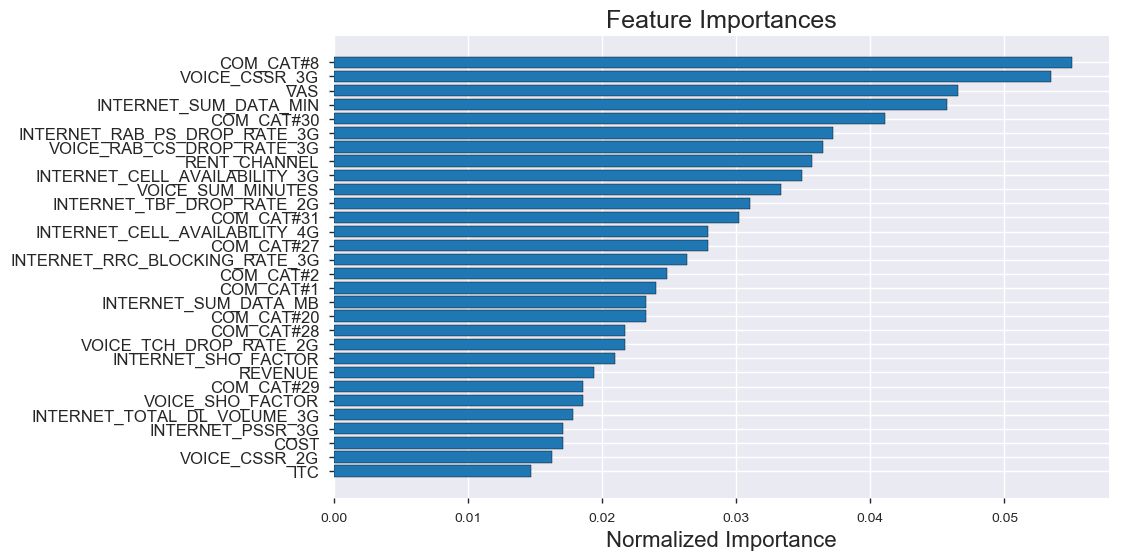

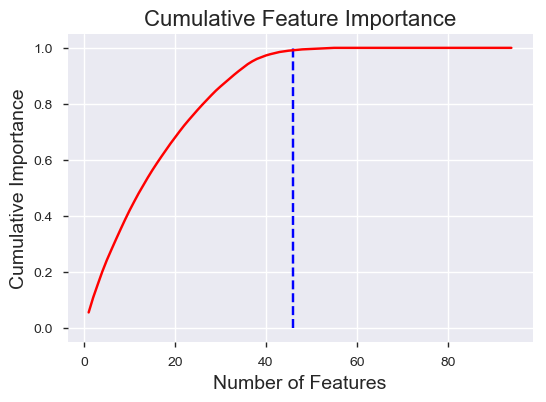

46 features required for 0.99 of cumulative importance


In [19]:
fs = FeatureSelector(data = X, labels = y)

fs.identify_all(selection_params = {'missing_threshold': 0.96, 'correlation_threshold': 0.98, 
                                    'task': 'classification', 'eval_metric': 'auc', 
                                     'cumulative_importance': 0.99})
fs.plot_feature_importances(threshold = 0.99, plot_n = 30)

We can see that the most important feature is COM_CAT#8. There is no any description of what it is 👍.  
But also we see that our "engineered" features like SUM_DATA_MIN are also important. Also it is easy to notice that "internet" features are more important than voice which is intuitively clear, because for now lots of clients use internet more often rather than voice calls.

In [21]:
train_removed_all_once = fs.remove(methods = 'all')

['missing', 'single_unique', 'collinear', 'zero_importance', 'low_importance'] methods have been run

Removed 56 features.


In [22]:
set(X.columns) - set(train_removed_all_once.columns)

{'COM_CAT#17',
 'COM_CAT#18',
 'COM_CAT#19',
 'COM_CAT#21',
 'COM_CAT#22',
 'COM_CAT#25',
 'COM_CAT#26',
 'COM_CAT#28',
 'COM_CAT#32',
 'COM_CAT#8',
 'INTERNET_CELL_AVAILABILITY_4G',
 'INTERNET_ERAB_PS_BLOCKING_RATE_LTE',
 'INTERNET_ERAB_PS_BLOCKING_RATE_PLMN_LTE',
 'INTERNET_ERAB_PS_DROP_RATE_LTE',
 'INTERNET_PART_CQI_QPSK_LTE',
 'INTERNET_PART_MCS_QPSK_LTE',
 'INTERNET_PSSR_LTE',
 'INTERNET_RBU_AVAIL_DL',
 'INTERNET_RBU_AVAIL_UL',
 'INTERNET_RBU_OTHER_DL',
 'INTERNET_RBU_OTHER_UL',
 'INTERNET_RBU_OWN_DL',
 'INTERNET_RBU_OWN_UL',
 'INTERNET_RRC_BLOCKING_RATE_LTE',
 'INTERNET_SHO_FACTOR',
 'ROAM',
 'VOICE_CELL_AVAILABILITY_2G',
 'VOICE_ERAB_PS_BLOCKING_RATE_LTE',
 'VOICE_RAB_CS_BLOCKING_RATE_3G',
 'VOICE_RBU_AVAIL_DL',
 'VOICE_RBU_AVAIL_UL',
 'VOICE_RBU_OTHER_DL',
 'VOICE_RBU_OTHER_UL',
 'VOICE_RBU_OWN_DL',
 'VOICE_RBU_OWN_UL',
 'VOICE_RRC_BLOCKING_RATE_3G'}

In [ ]:
#X = train_removed_all_once

In [23]:
profileReport.get_rejected_variables()

['COM_CAT#20',
 'COM_CAT#22',
 'COM_CAT#23',
 'COM_CAT#28',
 'COM_CAT#31',
 'INTERNET_CELL_AVAILABILITY_4G',
 'INTERNET_ERAB_PS_BLOCKING_RATE_PLMN_LTE',
 'INTERNET_RBU_AVAIL_DL',
 'INTERNET_RBU_AVAIL_UL',
 'INTERNET_RBU_OWN_DL',
 'INTERNET_RBU_OWN_UL',
 'INTERNET_SHO_FACTOR',
 'VOICE_RBU_AVAIL_UL',
 'VOICE_RBU_OWN_DL',
 'VOICE_RBU_OWN_UL',
 'VOICE_RRC_BLOCKING_RATE_3G']

So for now I only drop missing or collinear features

In [24]:
X = X.drop(columns=['COM_CAT#31', 'COM_CAT#20', 'COM_CAT#22', 'COM_CAT#23', 'COM_CAT#28', 'COM_CAT#31', 'COM_CAT#33', 'COM_CAT#34', 'VOICE_RBU_AVAIL_UL', 'VOICE_RBU_OWN_DL',
 'VOICE_RBU_OWN_UL', 'VOICE_RRC_BLOCKING_RATE_3G', 'INTERNET_ERAB_PS_BLOCKING_RATE_PLMN_LTE', 'INTERNET_RBU_AVAIL_UL', 'INTERNET_RBU_OWN_UL', 'INTERNET_RBU_OTHER_UL', 'INTERNET_RBU_OTHER_DL', 'VOICE_RBU_OTHER_DL', 'VOICE_RBU_OTHER_UL'])

In [25]:
categorical_features = list(set(X).intersection(categorical_features))
numerical_features = list(set(X).intersection(numerical_features))
binary_features = list(set(X).intersection(binary_features))

Below I do some strange things - different (but not really) pipelines for voice, internet and common columns. I do it because pipeline can blend columns (especially when using PolinomialFeatures (which I do not use at the moment because it gave bad results)). But for some methods I needed to know which columns are voice and which are internet but pipeline returns numpy array rather than pandas dataframe with names.

In [27]:
voice_columns = ['VOICE_SUM_MINUTES', 'VOICE_CELL_AVAILABILITY_2G',
       'VOICE_CELL_AVAILABILITY_3G', 'VOICE_CELL_AVAILABILITY_4G',
       'VOICE_CSSR_2G', 'VOICE_CSSR_3G', 'VOICE_ERAB_PS_BLOCKING_RATE_LTE',
       'VOICE_RAB_CS_BLOCKING_RATE_3G', 'VOICE_RAB_CS_DROP_RATE_3G',
       'VOICE_RBU_AVAIL_DL',
       'VOICE_SHO_FACTOR', 'VOICE_TCH_DROP_RATE_2G',]
internet_columns = ['INTERNET_SUM_DATA_MB',
       'INTERNET_SUM_DATA_MIN', 'INTERNET_CELL_AVAILABILITY_2G',
       'INTERNET_CELL_AVAILABILITY_3G', 'INTERNET_CELL_AVAILABILITY_4G',
       'INTERNET_ERAB_PS_BLOCKING_RATE_LTE', 'INTERNET_ERAB_PS_DROP_RATE_LTE',
       'INTERNET_PART_CQI_QPSK_LTE', 'INTERNET_PART_MCS_QPSK_LTE',
       'INTERNET_PSSR_2G', 'INTERNET_PSSR_3G', 'INTERNET_PSSR_LTE',
       'INTERNET_RAB_CS_BLOCKING_RATE_3G', 'INTERNET_RAB_PS_DROP_RATE_3G',
       'INTERNET_RBU_AVAIL_DL', 'INTERNET_RBU_OWN_DL',
       'INTERNET_RRC_BLOCKING_RATE_3G', 'INTERNET_RRC_BLOCKING_RATE_LTE',
       'INTERNET_SHO_FACTOR', 'INTERNET_TBF_DROP_RATE_2G',
       'INTERNET_TOTAL_DL_VOLUME_3G', 'INTERNET_TOTAL_UL_VOLUME_3G']

In [28]:
def getClassifierPipeline(categorical_features_sent, numerical_features_sent, binary_features_sent):
    return  Pipeline(steps = [       
            ('feature_processing', ColumnTransformer(transformers = [   
                    #categorical
                ('categorical', Pipeline([
                    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-10000)),
                    ('toint', FunctionTransformer(lambda x: x.astype('int64')))
                ]),
                categorical_features_sent),
                #binary
                ('binary', Pipeline([
                    ('impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))]),
                binary_features_sent), 

                #numeric
                ('numeric', Pipeline([
                    ('impute', SimpleImputer(missing_values=np.nan, strategy='mean', verbose=2)),
                    ('scale', RobustScaler()),
                    ('transform', QuantileTransformer(output_distribution='normal')),  # ('engineer', PolynomialFeatures())
                   ]),
                numerical_features_sent)      
        ])),
        ]
    )

These pipeline methods were acquired with the help of GridSearchCV and LogisticRegression. I removed this code too long ago and don't see any reason to recover it (there was nothing special), moreover some other features were used at that time. Also I was trying to use one-hot encoding and polynomial features but results were worse. I think I should have tried to use polynomial features only on most important ones.

I also use target encoding which gave better score rather than usual one-hot one for categorical. To be honest it is not the ideal implementation of this method (it does not use some kind of "cross-validation" inside for better precision) but it works

In [30]:
tgEnc = ce.TargetEncoder(cols=categorical_features)
tgEnc.fit(X, y)
X = tgEnc.transform(X.reset_index(drop=True))

In [31]:
voice_pipeline = getClassifierPipeline(binary_features_sent=[], categorical_features_sent=[], numerical_features_sent=voice_columns)
internet_pipeline = getClassifierPipeline(binary_features_sent=[], categorical_features_sent=[], numerical_features_sent=internet_columns)
others_pipeline = getClassifierPipeline(binary_features_sent=binary_features, categorical_features_sent=categorical_features,
                                        numerical_features_sent=list(set(numerical_features) - set(internet_columns)
                                                                - set(voice_columns)))

In [32]:
X_voice = voice_pipeline.fit_transform(X[voice_columns], y)

X_internet = internet_pipeline.fit_transform(X[internet_columns], y)

X_other = others_pipeline.fit_transform(X, y)

C:\Users\i503708\AppData\Local\Continuum\anaconda3\envs\mlbootcamp\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\Users\i503708\AppData\Local\Continuum\anaconda3\envs\mlbootcamp\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


In [33]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(X[list(set(numerical_features) - set(internet_columns)
                                                                - set(voice_columns))].count())

COM_CAT#21      4215
COM_CAT#19      4215
COST            4215
COM_CAT#7       4215
REVENUE         4215
COM_CAT#29      4215
COM_CAT#2       4215
ITC             4215
VAS             4215
COM_CAT#27      4215
COM_CAT#17      4215
COM_CAT#8       4204
COM_CAT#32      4215
COM_CAT#3       4215
ROAM            4215
COM_CAT#30      4215
RENT_CHANNEL    4215
COM_CAT#1       4215
COM_CAT#18      4215
dtype: int64


In [34]:
X_internet.shape[1] + X_voice.shape[1] + X_other.shape[1]

60

In [35]:
X_train_concat = np.concatenate((X_other, X_internet, X_voice), axis=1)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_train_concat, y, stratify=y, random_state=698)

In [37]:
np.concatenate((np.arange(0, 28), np.arange(46, 61)), axis=None)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60])

# Testing different models

## LightGBM (91 place)

It was the last model I used. These parameters are just from some random guy from Kaggle. Below I tried to tune them with the help of hyperopt and got better results on public leaderboard. However, on private these "baseline" parameters showed a little better result.

In [38]:
model = lightgbm.LGBMClassifier( 
            n_estimators=4000, 
            learning_rate=0.01, 
            num_leaves=30, 
            colsample_bytree=.9, 
            subsample=.4, 
            max_depth=7, 
            reg_alpha=.1, 
            reg_lambda=.1, 
            min_split_gain=.01, 
            min_child_weight=2, 
            silent=-1, 
            verbose=-1, 
            )

In [39]:
model.fit(X_train, y_train, 
eval_set = [(X_test, y_test)], 
eval_metric='auc', verbose=100)

[100]	valid_0's auc: 0.527288	valid_0's binary_logloss: 0.434785
[200]	valid_0's auc: 0.530597	valid_0's binary_logloss: 0.437399
[300]	valid_0's auc: 0.53712	valid_0's binary_logloss: 0.439652
[400]	valid_0's auc: 0.536257	valid_0's binary_logloss: 0.442782
[500]	valid_0's auc: 0.532982	valid_0's binary_logloss: 0.446113
[600]	valid_0's auc: 0.539155	valid_0's binary_logloss: 0.447391
[700]	valid_0's auc: 0.540936	valid_0's binary_logloss: 0.449685
[800]	valid_0's auc: 0.541011	valid_0's binary_logloss: 0.452048
[900]	valid_0's auc: 0.540634	valid_0's binary_logloss: 0.454977
[1000]	valid_0's auc: 0.542484	valid_0's binary_logloss: 0.457095
[1100]	valid_0's auc: 0.544492	valid_0's binary_logloss: 0.459625
[1200]	valid_0's auc: 0.545547	valid_0's binary_logloss: 0.462136
[1300]	valid_0's auc: 0.548301	valid_0's binary_logloss: 0.464683
[1400]	valid_0's auc: 0.54915	valid_0's binary_logloss: 0.468038
[1500]	valid_0's auc: 0.549102	valid_0's binary_logloss: 0.47236
[1600]	valid_0's auc: 

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9,
        importance_type='split', learning_rate=0.01, max_depth=7,
        min_child_samples=20, min_child_weight=2, min_split_gain=0.01,
        n_estimators=4000, n_jobs=-1, num_leaves=30, objective=None,
        random_state=None, reg_alpha=0.1, reg_lambda=0.1, silent=-1,
        subsample=0.4, subsample_for_bin=200000, subsample_freq=0,
        verbose=-1)

In [40]:
from hyperopt import fmin
import sklearn
from sklearn.metrics import make_scorer

In [42]:
def objective(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'subsample': '{:.3f}'.format(params['subsample']),
        'reg_lambda': '{:.3f}'.format(params['reg_lambda']),

    }
    
    clf = lightgbm.LGBMClassifier(
        n_estimators=4000, 
        learning_rate=0.01, 
        max_depth=7, 
        reg_alpha=.1, 
        min_split_gain=.01, 
        min_child_weight=2, 
        silent=-1, 
        verbose=-1, 
        **params
    )
    
    score = cross_val_score(clf, X_train, y_train, scoring = 'neg_log_loss'
, cv=StratifiedKFold()).mean()
    print("RocAuc {:.3f} params {}".format(score, params))
    return score

space = {
    'num_leaves': hp.quniform('num_leaves', 8, 128, 2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'subsample': hp.uniform('subsample', 0.1, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.1, 1.0)

}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)

C:\Users\i503708\AppData\Local\Continuum\anaconda3\envs\mlbootcamp\lib\site-packages\sklearn\model_selection\_split.py:624: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


RocAuc -0.612 params {'num_leaves': 28, 'colsample_bytree': '0.859', 'subsample': '0.144', 'reg_lambda': '0.712'}


C:\Users\i503708\AppData\Local\Continuum\anaconda3\envs\mlbootcamp\lib\site-packages\sklearn\model_selection\_split.py:624: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


RocAuc -0.604 params {'num_leaves': 104, 'colsample_bytree': '0.593', 'subsample': '0.826', 'reg_lambda': '0.630'}


C:\Users\i503708\AppData\Local\Continuum\anaconda3\envs\mlbootcamp\lib\site-packages\sklearn\model_selection\_split.py:624: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


RocAuc -0.612 params {'num_leaves': 118, 'colsample_bytree': '0.583', 'subsample': '0.865', 'reg_lambda': '0.195'}


C:\Users\i503708\AppData\Local\Continuum\anaconda3\envs\mlbootcamp\lib\site-packages\sklearn\model_selection\_split.py:624: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


RocAuc -0.614 params {'num_leaves': 46, 'colsample_bytree': '0.890', 'subsample': '0.337', 'reg_lambda': '0.791'}


C:\Users\i503708\AppData\Local\Continuum\anaconda3\envs\mlbootcamp\lib\site-packages\sklearn\model_selection\_split.py:624: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


RocAuc -0.587 params {'num_leaves': 60, 'colsample_bytree': '0.418', 'subsample': '0.989', 'reg_lambda': '0.801'}


C:\Users\i503708\AppData\Local\Continuum\anaconda3\envs\mlbootcamp\lib\site-packages\sklearn\model_selection\_split.py:624: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


RocAuc -0.596 params {'num_leaves': 44, 'colsample_bytree': '0.569', 'subsample': '0.941', 'reg_lambda': '0.795'}


C:\Users\i503708\AppData\Local\Continuum\anaconda3\envs\mlbootcamp\lib\site-packages\sklearn\model_selection\_split.py:624: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


RocAuc -0.622 params {'num_leaves': 54, 'colsample_bytree': '0.991', 'subsample': '0.651', 'reg_lambda': '0.614'}


C:\Users\i503708\AppData\Local\Continuum\anaconda3\envs\mlbootcamp\lib\site-packages\sklearn\model_selection\_split.py:624: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


RocAuc -0.610 params {'num_leaves': 56, 'colsample_bytree': '0.649', 'subsample': '0.723', 'reg_lambda': '0.430'}


C:\Users\i503708\AppData\Local\Continuum\anaconda3\envs\mlbootcamp\lib\site-packages\sklearn\model_selection\_split.py:624: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


RocAuc -0.611 params {'num_leaves': 72, 'colsample_bytree': '0.719', 'subsample': '0.633', 'reg_lambda': '0.464'}


C:\Users\i503708\AppData\Local\Continuum\anaconda3\envs\mlbootcamp\lib\site-packages\sklearn\model_selection\_split.py:624: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


RocAuc -0.587 params {'num_leaves': 102, 'colsample_bytree': '0.402', 'subsample': '0.322', 'reg_lambda': '0.824'}


## Catboost (91? place)

I also tried to use catboost. On public leaderboard my results were worse but on private it gave even better results than best lightGBM (I did not include this submission to final, but the growth was quite low)

In [44]:
catboost = CatBoostClassifier(iterations=1000, random_seed=999, 
                                        depth=7, learning_rate=0.01,
                                        leaf_estimation_iterations=30,
                                        rsm=.8,
                                        reg_lambda=.1,
                                        random_strength=.123,
                                        eval_metric="AUC",
                                        use_best_model=True,
                                        best_model_min_trees=200,
                                        loss_function='Logloss')
catboost.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## XGBoost

Didn't spend much time on tuning XGBoost as it gave worse results on baseline parameters than other gradient boosting methods. Moreover it is out of fashion in 2018.

In [43]:
from xgboost import XGBClassifier
# Initialize 2nd level model
model = XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, 
                      n_estimators=100, max_depth=2)
    
# Fit 2nd level model
model = model.fit(S_train_1, y_train)

## Model stacking

First of all I tried to add lightGBM and catboost classifiers and meta LogisticRegression. But it didn't work at all. Score was lower than 0.50

In [ ]:
ensemble = SuperLearner(scorer=roc_auc_score, random_state=42, verbose=2)
ensemble.add([CatBoostClassifier(iterations=2000, random_seed=666, 
                                        depth=4, learning_rate=0.1,
                                        cat_features=np.arange(0, len(categorical_features)),
                                        loss_function='Logloss'), lightgbm.LGBMClassifier(objective='binary', random_state=888, n_estimators=500,
        learning_rate=0.01, num_leaves=124, colsample_bytree=0.996)], proba=True)

In [ ]:
ensemble.add_meta(LogisticRegressionCV(cv=5), proba=True)

Here I tried to use model stacking. The idea was to train one model on common + voice data, other model on common + internet data. And then add meta_classifier - Logistic Regression. But the score even locally was so bad that I didn't try to send it (maybe it was false decision)

In [ ]:
preprocess_cases = {'intsub': [Subset(np.arange(0, 46))],
                    'voicesub': [Subset(np.concatenate((np.arange(0, 28), np.arange(46, 61)), axis=None))]}
# We can map different estimators to different cases

ests_1 = [lightgbm.LGBMClassifier( 
                n_estimators=4000, 
                learning_rate=0.01, 
                num_leaves=30, 
                colsample_bytree=.8, 
                subsample=.9, 
                max_depth=7, 
                reg_alpha=.1, 
                reg_lambda=.1, 
                min_split_gain=.01, 
                min_child_weight=2, 
                silent=-1, 
                verbose=-1, 
                ),lightgbm.LGBMClassifier( 
                n_estimators=4000, 
                learning_rate=0.01, 
                num_leaves=30, 
                colsample_bytree=.8, 
                subsample=.9, 
                max_depth=7, 
                reg_alpha=.1, 
                reg_lambda=.1, 
                min_split_gain=.01, 
                min_child_weight=2, 
                silent=-1, 
                verbose=-1, 
                )]
ests_2 = [CatBoostClassifier(iterations=2000, random_seed=666, 
                                        depth=4, learning_rate=0.1,
                                        loss_function='Logloss'), lightgbm.LGBMClassifier( 
            n_estimators=4000, 
            learning_rate=0.01, 
            num_leaves=30, 
            colsample_bytree=.8, 
            subsample=.9, 
            max_depth=7, 
            reg_alpha=.1, 
            reg_lambda=.1, 
            min_split_gain=.01, 
            min_child_weight=2, 
            silent=-1, 
            verbose=-1, 
            )]


preproc = {'intsub': [ests_1[0]],
           'voicesub': [ests_1[1]]}
ensemble = SuperLearner(scorer=roc_auc_score, random_state=42, verbose=2)
ensemble.add(estimators=preproc, preprocessing=preprocess_cases, proba=True)
ensemble.add_meta(LogisticRegressionCV(cv=5), proba=True)

In [ ]:
ensemble.fit(X_train, y_train)

The second idea was to build clustered subsemble using unsupervised learning inside. But it just failed

In [ ]:
from sklearn.cluster import KMeans

def build_clustered_subsemble(estimator):
    """Build a subsemble with random partitions"""
    sub = Subsemble(partitions=2,
                    partition_estimator=estimator,
                    folds=2, verbose=2)

    sub.add([lightgbm.LGBMClassifier( 
            random_state=888,
            n_estimators=4000, 
            learning_rate=0.01, 
            num_leaves=30, 
            colsample_bytree=.8, 
            subsample=.9, 
            max_depth=7, 
            reg_alpha=.1, 
            reg_lambda=.1, 
            min_split_gain=.01, 
            min_child_weight=2, 
            silent=-1, 
            verbose=-1, 
            ), lightgbm.LGBMClassifier( 
            random_state=24563,
            n_estimators=4000, 
            learning_rate=0.01, 
            num_leaves=30, 
            colsample_bytree=.8, 
            subsample=.9, 
            max_depth=7, 
            reg_alpha=.1, 
            reg_lambda=.1, 
            min_split_gain=.01, 
            min_child_weight=2, 
            silent=-1, 
            verbose=-1, 
            )], proba=True)
    sub.add_meta(SVC(probability=True), proba=True)
    return sub

sub = build_clustered_subsemble(KMeans(2))
sub.fit(X_train, y_train)

Then I tried to use other stacking library and use practically all "simple" algorithms. Here you can see that logistic regression worked badly with my preprocessing. The whole result gave score similar to just one Catboost or lightGBM.

In [45]:
def auc(y_true, y_pred):
    """ROC AUC metric for both binary and multiclass classification.
    
    Parameters
    ----------
    y_true : 1d numpy array
        True class labels
    y_pred : 2d numpy array
        Predicted probabilities for each class
    """
    ohe = OneHotEncoder(sparse=False)
    y_true = ohe.fit_transform(y_true.reshape(-1, 1))
    auc_score = roc_auc_score(y_true, y_pred)
    return auc_score

In [27]:
from vecstack import stacking
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

models_1 = [ 
    GaussianNB(),
    
    LogisticRegression(random_state=0),
                  
    CatBoostClassifier(iterations=2000, random_seed=999, 
                                        depth=7, learning_rate=0.01,
                                        leaf_estimation_iterations=30,
                                        rsm=.8,
                                        reg_lambda=.1,
                                        random_strength=.123,
                                        loss_function='Logloss'),
    
    lightgbm.LGBMClassifier( 
            n_estimators=4000, 
            learning_rate=0.01, 
            num_leaves=30, 
            colsample_bytree=.8, 
            subsample=.9, 
            max_depth=7, 
            reg_alpha=.1, 
            reg_lambda=.1, 
            min_split_gain=.01, 
            min_child_weight=2, 
            silent=-1, 
            verbose=-1, 
            ),
    XGBClassifier(random_state=0,
                 max_depth=7,
                 learning_rate=0.01,
                 n_estimators=4000,
                 n_jobs=4,
                 min_child_weight=2,
                 subsample=0.9,
                 colsample_bytree=.8,
                 reg_alpha=.1, 
                 reg_lambda=.1,
                 )
]

In [28]:
S_train_1, S_test_1 = stacking(models_1,                   # list of models
                               X_train, y_train, X_test,   # data
                               regression=False,           # classification task (if you need 
                                                           #     regression - set to True)
                               mode='oof_pred',            # mode: oof for train set, fit on full 
                                                           #     train and predict test set once
                               needs_proba=True,           # predict probabilities (if you need 
                                                           #     class labels - set to False) 
                               save_dir='.',               # save result and log in current dir 
                                                           #     (to disable saving - set to None)
                               metric=auc,            # metric: callable
                               n_folds=5,                  # number of folds
                               stratified=True,            # stratified split for folds
                               shuffle=True,               # shuffle the data
                               random_state=0,             # ensure reproducibility
                               verbose=2)  

task:         [classification]
n_classes:    [2]
metric:       [auc]
mode:         [oof_pred]
n_models:     [5]

model  0:     [GaussianNB]
    fold  0:  [0.53118920]
    fold  1:  [0.53754395]
    fold  2:  [0.51686349]
    fold  3:  [0.49872449]
    fold  4:  [0.52860105]
    ----
    MEAN:     [0.52258444] + [0.01368251]
    FULL:     [0.50633123]

    Fitting on full train set...

model  1:     [LogisticRegression]


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In c

    fold  0:  [0.52279229]
    fold  1:  [0.53170144]


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determine

    fold  2:  [0.56743484]
    fold  3:  [0.49040740]


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determine

    fold  4:  [0.55453642]
    ----
    MEAN:     [0.53337448] + [0.02671661]
    FULL:     [0.53308170]

    Fitting on full train set...

model  2:     [CatBoostClassifier]
0:	learn: 0.6870817	total: 57.4ms	remaining: 1m 54s
1:	learn: 0.6809535	total: 110ms	remaining: 1m 50s
2:	learn: 0.6748020	total: 158ms	remaining: 1m 44s
3:	learn: 0.6689830	total: 199ms	remaining: 1m 39s
4:	learn: 0.6632292	total: 240ms	remaining: 1m 35s
5:	learn: 0.6574875	total: 280ms	remaining: 1m 33s
6:	learn: 0.6519133	total: 324ms	remaining: 1m 32s
7:	learn: 0.6465620	total: 367ms	remaining: 1m 31s
8:	learn: 0.6410778	total: 413ms	remaining: 1m 31s
9:	learn: 0.6357789	total: 474ms	remaining: 1m 34s
10:	learn: 0.6310072	total: 502ms	remaining: 1m 30s
11:	learn: 0.6262337	total: 546ms	remaining: 1m 30s
12:	learn: 0.6213193	total: 605ms	remaining: 1m 32s
13:	learn: 0.6166948	total: 670ms	remaining: 1m 35s
14:	learn: 0.6120859	total: 712ms	remaining: 1m 34s
15:	learn: 0.6075591	total: 762ms	remaining: 1m 34s
16

161:	learn: 0.3874338	total: 5.72s	remaining: 1m 4s
162:	learn: 0.3869145	total: 5.75s	remaining: 1m 4s
163:	learn: 0.3863396	total: 5.78s	remaining: 1m 4s
164:	learn: 0.3859245	total: 5.81s	remaining: 1m 4s
165:	learn: 0.3852199	total: 5.84s	remaining: 1m 4s
166:	learn: 0.3846632	total: 5.88s	remaining: 1m 4s
167:	learn: 0.3841413	total: 5.91s	remaining: 1m 4s
168:	learn: 0.3838155	total: 5.95s	remaining: 1m 4s
169:	learn: 0.3833620	total: 5.98s	remaining: 1m 4s
170:	learn: 0.3830610	total: 6.01s	remaining: 1m 4s
171:	learn: 0.3823573	total: 6.04s	remaining: 1m 4s
172:	learn: 0.3819087	total: 6.07s	remaining: 1m 4s
173:	learn: 0.3817141	total: 6.11s	remaining: 1m 4s
174:	learn: 0.3812073	total: 6.13s	remaining: 1m 3s
175:	learn: 0.3808773	total: 6.17s	remaining: 1m 3s
176:	learn: 0.3804360	total: 6.21s	remaining: 1m 3s
177:	learn: 0.3800095	total: 6.24s	remaining: 1m 3s
178:	learn: 0.3797123	total: 6.27s	remaining: 1m 3s
179:	learn: 0.3793890	total: 6.3s	remaining: 1m 3s
180:	learn: 0

327:	learn: 0.3456482	total: 11.5s	remaining: 58.8s
328:	learn: 0.3455317	total: 11.6s	remaining: 58.8s
329:	learn: 0.3453226	total: 11.6s	remaining: 58.8s
330:	learn: 0.3451072	total: 11.7s	remaining: 58.8s
331:	learn: 0.3450228	total: 11.7s	remaining: 58.7s
332:	learn: 0.3449928	total: 11.7s	remaining: 58.7s
333:	learn: 0.3448679	total: 11.8s	remaining: 58.7s
334:	learn: 0.3448449	total: 11.8s	remaining: 58.6s
335:	learn: 0.3448410	total: 11.8s	remaining: 58.5s
336:	learn: 0.3446600	total: 11.8s	remaining: 58.5s
337:	learn: 0.3445914	total: 11.9s	remaining: 58.4s
338:	learn: 0.3443520	total: 11.9s	remaining: 58.4s
339:	learn: 0.3442337	total: 11.9s	remaining: 58.3s
340:	learn: 0.3440481	total: 12s	remaining: 58.3s
341:	learn: 0.3438712	total: 12s	remaining: 58.3s
342:	learn: 0.3438023	total: 12.1s	remaining: 58.2s
343:	learn: 0.3437073	total: 12.1s	remaining: 58.2s
344:	learn: 0.3436374	total: 12.1s	remaining: 58.1s
345:	learn: 0.3433990	total: 12.1s	remaining: 58.1s
346:	learn: 0.34

491:	learn: 0.3261202	total: 17.2s	remaining: 52.7s
492:	learn: 0.3258688	total: 17.2s	remaining: 52.7s
493:	learn: 0.3258212	total: 17.3s	remaining: 52.6s
494:	learn: 0.3257942	total: 17.3s	remaining: 52.6s
495:	learn: 0.3256414	total: 17.3s	remaining: 52.5s
496:	learn: 0.3255294	total: 17.4s	remaining: 52.5s
497:	learn: 0.3253171	total: 17.4s	remaining: 52.4s
498:	learn: 0.3252441	total: 17.4s	remaining: 52.4s
499:	learn: 0.3251999	total: 17.5s	remaining: 52.4s
500:	learn: 0.3251901	total: 17.5s	remaining: 52.3s
501:	learn: 0.3251271	total: 17.5s	remaining: 52.3s
502:	learn: 0.3249035	total: 17.5s	remaining: 52.2s
503:	learn: 0.3248769	total: 17.6s	remaining: 52.2s
504:	learn: 0.3247366	total: 17.6s	remaining: 52.1s
505:	learn: 0.3245581	total: 17.6s	remaining: 52.1s
506:	learn: 0.3245218	total: 17.7s	remaining: 52.1s
507:	learn: 0.3243914	total: 17.7s	remaining: 52s
508:	learn: 0.3243583	total: 17.7s	remaining: 52s
509:	learn: 0.3240290	total: 17.8s	remaining: 51.9s
510:	learn: 0.32

653:	learn: 0.3080412	total: 22.7s	remaining: 46.6s
654:	learn: 0.3078399	total: 22.7s	remaining: 46.6s
655:	learn: 0.3077105	total: 22.8s	remaining: 46.6s
656:	learn: 0.3076573	total: 22.8s	remaining: 46.6s
657:	learn: 0.3075455	total: 22.9s	remaining: 46.6s
658:	learn: 0.3075280	total: 22.9s	remaining: 46.6s
659:	learn: 0.3073456	total: 23s	remaining: 46.6s
660:	learn: 0.3071924	total: 23s	remaining: 46.6s
661:	learn: 0.3071382	total: 23.1s	remaining: 46.6s
662:	learn: 0.3071057	total: 23.1s	remaining: 46.6s
663:	learn: 0.3070318	total: 23.1s	remaining: 46.6s
664:	learn: 0.3069967	total: 23.2s	remaining: 46.5s
665:	learn: 0.3069729	total: 23.2s	remaining: 46.5s
666:	learn: 0.3068821	total: 23.3s	remaining: 46.5s
667:	learn: 0.3066827	total: 23.3s	remaining: 46.5s
668:	learn: 0.3064511	total: 23.3s	remaining: 46.4s
669:	learn: 0.3063918	total: 23.4s	remaining: 46.4s
670:	learn: 0.3063284	total: 23.4s	remaining: 46.4s
671:	learn: 0.3062397	total: 23.4s	remaining: 46.3s
672:	learn: 0.30

817:	learn: 0.2939806	total: 28.3s	remaining: 40.9s
818:	learn: 0.2939454	total: 28.3s	remaining: 40.8s
819:	learn: 0.2938020	total: 28.4s	remaining: 40.8s
820:	learn: 0.2936508	total: 28.4s	remaining: 40.8s
821:	learn: 0.2936303	total: 28.4s	remaining: 40.7s
822:	learn: 0.2936011	total: 28.4s	remaining: 40.7s
823:	learn: 0.2934630	total: 28.5s	remaining: 40.6s
824:	learn: 0.2934208	total: 28.5s	remaining: 40.6s
825:	learn: 0.2933016	total: 28.5s	remaining: 40.6s
826:	learn: 0.2932263	total: 28.6s	remaining: 40.5s
827:	learn: 0.2932070	total: 28.6s	remaining: 40.5s
828:	learn: 0.2931937	total: 28.6s	remaining: 40.4s
829:	learn: 0.2931797	total: 28.7s	remaining: 40.4s
830:	learn: 0.2929020	total: 28.7s	remaining: 40.4s
831:	learn: 0.2928229	total: 28.7s	remaining: 40.3s
832:	learn: 0.2928091	total: 28.8s	remaining: 40.3s
833:	learn: 0.2927455	total: 28.8s	remaining: 40.3s
834:	learn: 0.2926516	total: 28.8s	remaining: 40.2s
835:	learn: 0.2926174	total: 28.9s	remaining: 40.2s
836:	learn: 

976:	learn: 0.2834268	total: 33.9s	remaining: 35.5s
977:	learn: 0.2834179	total: 34s	remaining: 35.5s
978:	learn: 0.2834098	total: 34s	remaining: 35.4s
979:	learn: 0.2834028	total: 34s	remaining: 35.4s
980:	learn: 0.2833766	total: 34s	remaining: 35.4s
981:	learn: 0.2833396	total: 34.1s	remaining: 35.3s
982:	learn: 0.2833079	total: 34.1s	remaining: 35.3s
983:	learn: 0.2832568	total: 34.1s	remaining: 35.3s
984:	learn: 0.2830637	total: 34.2s	remaining: 35.2s
985:	learn: 0.2829656	total: 34.2s	remaining: 35.2s
986:	learn: 0.2829358	total: 34.2s	remaining: 35.1s
987:	learn: 0.2829240	total: 34.3s	remaining: 35.1s
988:	learn: 0.2827405	total: 34.3s	remaining: 35.1s
989:	learn: 0.2825951	total: 34.3s	remaining: 35s
990:	learn: 0.2825778	total: 34.4s	remaining: 35s
991:	learn: 0.2825578	total: 34.4s	remaining: 34.9s
992:	learn: 0.2825495	total: 34.4s	remaining: 34.9s
993:	learn: 0.2825261	total: 34.4s	remaining: 34.9s
994:	learn: 0.2825139	total: 34.5s	remaining: 34.8s
995:	learn: 0.2825044	to

1138:	learn: 0.2756294	total: 39.7s	remaining: 30s
1139:	learn: 0.2755784	total: 39.7s	remaining: 30s
1140:	learn: 0.2755735	total: 39.7s	remaining: 29.9s
1141:	learn: 0.2755536	total: 39.8s	remaining: 29.9s
1142:	learn: 0.2755082	total: 39.8s	remaining: 29.9s
1143:	learn: 0.2754866	total: 39.8s	remaining: 29.8s
1144:	learn: 0.2753585	total: 39.9s	remaining: 29.8s
1145:	learn: 0.2753522	total: 39.9s	remaining: 29.7s
1146:	learn: 0.2753502	total: 39.9s	remaining: 29.7s
1147:	learn: 0.2753185	total: 40s	remaining: 29.7s
1148:	learn: 0.2753161	total: 40s	remaining: 29.6s
1149:	learn: 0.2752257	total: 40s	remaining: 29.6s
1150:	learn: 0.2752205	total: 40.1s	remaining: 29.6s
1151:	learn: 0.2751921	total: 40.1s	remaining: 29.5s
1152:	learn: 0.2750329	total: 40.1s	remaining: 29.5s
1153:	learn: 0.2750113	total: 40.2s	remaining: 29.4s
1154:	learn: 0.2749492	total: 40.2s	remaining: 29.4s
1155:	learn: 0.2748834	total: 40.2s	remaining: 29.4s
1156:	learn: 0.2747578	total: 40.3s	remaining: 29.3s
115

1299:	learn: 0.2700085	total: 45.3s	remaining: 24.4s
1300:	learn: 0.2698632	total: 45.3s	remaining: 24.4s
1301:	learn: 0.2698005	total: 45.4s	remaining: 24.3s
1302:	learn: 0.2695192	total: 45.4s	remaining: 24.3s
1303:	learn: 0.2695053	total: 45.4s	remaining: 24.3s
1304:	learn: 0.2694272	total: 45.5s	remaining: 24.2s
1305:	learn: 0.2694197	total: 45.5s	remaining: 24.2s
1306:	learn: 0.2694172	total: 45.6s	remaining: 24.2s
1307:	learn: 0.2693849	total: 45.6s	remaining: 24.1s
1308:	learn: 0.2693730	total: 45.6s	remaining: 24.1s
1309:	learn: 0.2693670	total: 45.7s	remaining: 24.1s
1310:	learn: 0.2693425	total: 45.7s	remaining: 24s
1311:	learn: 0.2693406	total: 45.8s	remaining: 24s
1312:	learn: 0.2693032	total: 45.8s	remaining: 24s
1313:	learn: 0.2692927	total: 45.8s	remaining: 23.9s
1314:	learn: 0.2692886	total: 45.9s	remaining: 23.9s
1315:	learn: 0.2692866	total: 45.9s	remaining: 23.9s
1316:	learn: 0.2691399	total: 45.9s	remaining: 23.8s
1317:	learn: 0.2688973	total: 46s	remaining: 23.8s
1

1457:	learn: 0.2644027	total: 50.5s	remaining: 18.8s
1458:	learn: 0.2643909	total: 50.5s	remaining: 18.7s
1459:	learn: 0.2643861	total: 50.5s	remaining: 18.7s
1460:	learn: 0.2642840	total: 50.5s	remaining: 18.6s
1461:	learn: 0.2642830	total: 50.6s	remaining: 18.6s
1462:	learn: 0.2642801	total: 50.6s	remaining: 18.6s
1463:	learn: 0.2642672	total: 50.6s	remaining: 18.5s
1464:	learn: 0.2642651	total: 50.7s	remaining: 18.5s
1465:	learn: 0.2642472	total: 50.7s	remaining: 18.5s
1466:	learn: 0.2642431	total: 50.7s	remaining: 18.4s
1467:	learn: 0.2641495	total: 50.8s	remaining: 18.4s
1468:	learn: 0.2641417	total: 50.8s	remaining: 18.4s
1469:	learn: 0.2641246	total: 50.9s	remaining: 18.3s
1470:	learn: 0.2640035	total: 50.9s	remaining: 18.3s
1471:	learn: 0.2640007	total: 50.9s	remaining: 18.3s
1472:	learn: 0.2639615	total: 51s	remaining: 18.2s
1473:	learn: 0.2639581	total: 51s	remaining: 18.2s
1474:	learn: 0.2639559	total: 51.1s	remaining: 18.2s
1475:	learn: 0.2639238	total: 51.1s	remaining: 18.

1616:	learn: 0.2606128	total: 56s	remaining: 13.3s
1617:	learn: 0.2605980	total: 56.1s	remaining: 13.2s
1618:	learn: 0.2605868	total: 56.1s	remaining: 13.2s
1619:	learn: 0.2605848	total: 56.1s	remaining: 13.2s
1620:	learn: 0.2605788	total: 56.2s	remaining: 13.1s
1621:	learn: 0.2605688	total: 56.2s	remaining: 13.1s
1622:	learn: 0.2605305	total: 56.2s	remaining: 13.1s
1623:	learn: 0.2603467	total: 56.3s	remaining: 13s
1624:	learn: 0.2603423	total: 56.3s	remaining: 13s
1625:	learn: 0.2603398	total: 56.3s	remaining: 13s
1626:	learn: 0.2603381	total: 56.4s	remaining: 12.9s
1627:	learn: 0.2603346	total: 56.4s	remaining: 12.9s
1628:	learn: 0.2603043	total: 56.4s	remaining: 12.8s
1629:	learn: 0.2603012	total: 56.4s	remaining: 12.8s
1630:	learn: 0.2602916	total: 56.5s	remaining: 12.8s
1631:	learn: 0.2602899	total: 56.5s	remaining: 12.7s
1632:	learn: 0.2602849	total: 56.5s	remaining: 12.7s
1633:	learn: 0.2602829	total: 56.6s	remaining: 12.7s
1634:	learn: 0.2602764	total: 56.6s	remaining: 12.6s
1

1779:	learn: 0.2568723	total: 1m 1s	remaining: 7.64s
1780:	learn: 0.2568690	total: 1m 1s	remaining: 7.6s
1781:	learn: 0.2568599	total: 1m 1s	remaining: 7.57s
1782:	learn: 0.2568569	total: 1m 1s	remaining: 7.53s
1783:	learn: 0.2568533	total: 1m 1s	remaining: 7.5s
1784:	learn: 0.2568457	total: 1m 1s	remaining: 7.46s
1785:	learn: 0.2567594	total: 1m 1s	remaining: 7.42s
1786:	learn: 0.2567478	total: 1m 2s	remaining: 7.39s
1787:	learn: 0.2567390	total: 1m 2s	remaining: 7.36s
1788:	learn: 0.2567386	total: 1m 2s	remaining: 7.32s
1789:	learn: 0.2567348	total: 1m 2s	remaining: 7.29s
1790:	learn: 0.2567308	total: 1m 2s	remaining: 7.25s
1791:	learn: 0.2567280	total: 1m 2s	remaining: 7.21s
1792:	learn: 0.2567195	total: 1m 2s	remaining: 7.18s
1793:	learn: 0.2567181	total: 1m 2s	remaining: 7.15s
1794:	learn: 0.2567168	total: 1m 2s	remaining: 7.11s
1795:	learn: 0.2567138	total: 1m 2s	remaining: 7.08s
1796:	learn: 0.2567096	total: 1m 2s	remaining: 7.04s
1797:	learn: 0.2567075	total: 1m 2s	remaining: 7

1935:	learn: 0.2546113	total: 1m 7s	remaining: 2.22s
1936:	learn: 0.2546100	total: 1m 7s	remaining: 2.19s
1937:	learn: 0.2546090	total: 1m 7s	remaining: 2.15s
1938:	learn: 0.2546026	total: 1m 7s	remaining: 2.12s
1939:	learn: 0.2546017	total: 1m 7s	remaining: 2.08s
1940:	learn: 0.2545764	total: 1m 7s	remaining: 2.05s
1941:	learn: 0.2545762	total: 1m 7s	remaining: 2.02s
1942:	learn: 0.2545717	total: 1m 7s	remaining: 1.98s
1943:	learn: 0.2545473	total: 1m 7s	remaining: 1.95s
1944:	learn: 0.2545446	total: 1m 7s	remaining: 1.91s
1945:	learn: 0.2545428	total: 1m 7s	remaining: 1.88s
1946:	learn: 0.2545360	total: 1m 7s	remaining: 1.84s
1947:	learn: 0.2545343	total: 1m 7s	remaining: 1.81s
1948:	learn: 0.2545341	total: 1m 7s	remaining: 1.77s
1949:	learn: 0.2545322	total: 1m 7s	remaining: 1.74s
1950:	learn: 0.2545313	total: 1m 7s	remaining: 1.7s
1951:	learn: 0.2545080	total: 1m 7s	remaining: 1.67s
1952:	learn: 0.2545061	total: 1m 7s	remaining: 1.63s
1953:	learn: 0.2545047	total: 1m 7s	remaining: 

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


2:	learn: 0.6745962	total: 95.3ms	remaining: 1m 3s
3:	learn: 0.6690353	total: 125ms	remaining: 1m 2s
4:	learn: 0.6633698	total: 156ms	remaining: 1m 2s
5:	learn: 0.6578641	total: 193ms	remaining: 1m 4s
6:	learn: 0.6523892	total: 226ms	remaining: 1m 4s
7:	learn: 0.6470467	total: 257ms	remaining: 1m 3s
8:	learn: 0.6416508	total: 288ms	remaining: 1m 3s
9:	learn: 0.6366687	total: 320ms	remaining: 1m 3s
10:	learn: 0.6315530	total: 352ms	remaining: 1m 3s
11:	learn: 0.6268043	total: 383ms	remaining: 1m 3s
12:	learn: 0.6221003	total: 415ms	remaining: 1m 3s
13:	learn: 0.6173005	total: 446ms	remaining: 1m 3s
14:	learn: 0.6129593	total: 477ms	remaining: 1m 3s
15:	learn: 0.6082345	total: 509ms	remaining: 1m 3s
16:	learn: 0.6038854	total: 544ms	remaining: 1m 3s
17:	learn: 0.5994181	total: 575ms	remaining: 1m 3s
18:	learn: 0.5949337	total: 606ms	remaining: 1m 3s
19:	learn: 0.5908155	total: 637ms	remaining: 1m 3s
20:	learn: 0.5865028	total: 668ms	remaining: 1m 2s
21:	learn: 0.5828082	total: 698ms	rema

164:	learn: 0.3888710	total: 5.86s	remaining: 1m 5s
165:	learn: 0.3884205	total: 5.89s	remaining: 1m 5s
166:	learn: 0.3882179	total: 5.93s	remaining: 1m 5s
167:	learn: 0.3877836	total: 5.97s	remaining: 1m 5s
168:	learn: 0.3874552	total: 6.01s	remaining: 1m 5s
169:	learn: 0.3870621	total: 6.05s	remaining: 1m 5s
170:	learn: 0.3866682	total: 6.08s	remaining: 1m 5s
171:	learn: 0.3863922	total: 6.12s	remaining: 1m 5s
172:	learn: 0.3860733	total: 6.16s	remaining: 1m 5s
173:	learn: 0.3857975	total: 6.19s	remaining: 1m 4s
174:	learn: 0.3854032	total: 6.22s	remaining: 1m 4s
175:	learn: 0.3848737	total: 6.25s	remaining: 1m 4s
176:	learn: 0.3845495	total: 6.28s	remaining: 1m 4s
177:	learn: 0.3843232	total: 6.32s	remaining: 1m 4s
178:	learn: 0.3837425	total: 6.35s	remaining: 1m 4s
179:	learn: 0.3833490	total: 6.38s	remaining: 1m 4s
180:	learn: 0.3829072	total: 6.41s	remaining: 1m 4s
181:	learn: 0.3825458	total: 6.45s	remaining: 1m 4s
182:	learn: 0.3819325	total: 6.48s	remaining: 1m 4s
183:	learn: 

325:	learn: 0.3454098	total: 11.3s	remaining: 57.9s
326:	learn: 0.3453766	total: 11.3s	remaining: 57.9s
327:	learn: 0.3452932	total: 11.4s	remaining: 57.9s
328:	learn: 0.3451818	total: 11.4s	remaining: 57.9s
329:	learn: 0.3450166	total: 11.4s	remaining: 57.9s
330:	learn: 0.3447913	total: 11.5s	remaining: 57.9s
331:	learn: 0.3446680	total: 11.5s	remaining: 57.9s
332:	learn: 0.3445145	total: 11.6s	remaining: 57.9s
333:	learn: 0.3442944	total: 11.6s	remaining: 57.9s
334:	learn: 0.3438792	total: 11.6s	remaining: 57.9s
335:	learn: 0.3436103	total: 11.7s	remaining: 57.9s
336:	learn: 0.3436078	total: 11.7s	remaining: 57.9s
337:	learn: 0.3435372	total: 11.8s	remaining: 57.9s
338:	learn: 0.3432333	total: 11.8s	remaining: 57.9s
339:	learn: 0.3431620	total: 11.9s	remaining: 57.9s
340:	learn: 0.3428725	total: 11.9s	remaining: 57.9s
341:	learn: 0.3426787	total: 12s	remaining: 58s
342:	learn: 0.3424194	total: 12s	remaining: 58s
343:	learn: 0.3421175	total: 12s	remaining: 57.9s
344:	learn: 0.3419645	

487:	learn: 0.3241486	total: 16.8s	remaining: 52s
488:	learn: 0.3240792	total: 16.8s	remaining: 51.9s
489:	learn: 0.3239936	total: 16.8s	remaining: 51.9s
490:	learn: 0.3237385	total: 16.9s	remaining: 51.9s
491:	learn: 0.3235185	total: 16.9s	remaining: 51.8s
492:	learn: 0.3235048	total: 16.9s	remaining: 51.8s
493:	learn: 0.3232946	total: 17s	remaining: 51.8s
494:	learn: 0.3231071	total: 17s	remaining: 51.7s
495:	learn: 0.3230673	total: 17s	remaining: 51.7s
496:	learn: 0.3229764	total: 17.1s	remaining: 51.6s
497:	learn: 0.3229067	total: 17.1s	remaining: 51.6s
498:	learn: 0.3228598	total: 17.1s	remaining: 51.6s
499:	learn: 0.3227047	total: 17.2s	remaining: 51.5s
500:	learn: 0.3225805	total: 17.2s	remaining: 51.5s
501:	learn: 0.3225186	total: 17.2s	remaining: 51.5s
502:	learn: 0.3223912	total: 17.3s	remaining: 51.4s
503:	learn: 0.3222125	total: 17.3s	remaining: 51.4s
504:	learn: 0.3220268	total: 17.4s	remaining: 51.4s
505:	learn: 0.3219384	total: 17.4s	remaining: 51.3s
506:	learn: 0.321618

652:	learn: 0.3073118	total: 22.6s	remaining: 46.6s
653:	learn: 0.3072778	total: 22.6s	remaining: 46.6s
654:	learn: 0.3072639	total: 22.7s	remaining: 46.5s
655:	learn: 0.3071784	total: 22.7s	remaining: 46.5s
656:	learn: 0.3071151	total: 22.7s	remaining: 46.4s
657:	learn: 0.3070748	total: 22.7s	remaining: 46.4s
658:	learn: 0.3070628	total: 22.8s	remaining: 46.3s
659:	learn: 0.3070333	total: 22.8s	remaining: 46.3s
660:	learn: 0.3069979	total: 22.8s	remaining: 46.3s
661:	learn: 0.3069178	total: 22.9s	remaining: 46.2s
662:	learn: 0.3069029	total: 22.9s	remaining: 46.2s
663:	learn: 0.3068615	total: 22.9s	remaining: 46.2s
664:	learn: 0.3067536	total: 23s	remaining: 46.1s
665:	learn: 0.3066958	total: 23s	remaining: 46.1s
666:	learn: 0.3066676	total: 23s	remaining: 46s
667:	learn: 0.3066547	total: 23.1s	remaining: 46s
668:	learn: 0.3066267	total: 23.1s	remaining: 46s
669:	learn: 0.3066166	total: 23.1s	remaining: 45.9s
670:	learn: 0.3065339	total: 23.2s	remaining: 45.9s
671:	learn: 0.3065083	to

814:	learn: 0.2970125	total: 28.3s	remaining: 41.2s
815:	learn: 0.2969857	total: 28.4s	remaining: 41.1s
816:	learn: 0.2969621	total: 28.4s	remaining: 41.1s
817:	learn: 0.2969460	total: 28.4s	remaining: 41.1s
818:	learn: 0.2969304	total: 28.5s	remaining: 41s
819:	learn: 0.2968151	total: 28.5s	remaining: 41s
820:	learn: 0.2967899	total: 28.5s	remaining: 41s
821:	learn: 0.2967818	total: 28.6s	remaining: 40.9s
822:	learn: 0.2967198	total: 28.6s	remaining: 40.9s
823:	learn: 0.2966380	total: 28.6s	remaining: 40.8s
824:	learn: 0.2966229	total: 28.6s	remaining: 40.8s
825:	learn: 0.2965489	total: 28.7s	remaining: 40.8s
826:	learn: 0.2965276	total: 28.7s	remaining: 40.7s
827:	learn: 0.2964824	total: 28.7s	remaining: 40.7s
828:	learn: 0.2964636	total: 28.8s	remaining: 40.6s
829:	learn: 0.2963972	total: 28.8s	remaining: 40.6s
830:	learn: 0.2963858	total: 28.8s	remaining: 40.6s
831:	learn: 0.2963505	total: 28.9s	remaining: 40.5s
832:	learn: 0.2962560	total: 28.9s	remaining: 40.5s
833:	learn: 0.2960

975:	learn: 0.2880740	total: 33.7s	remaining: 35.4s
976:	learn: 0.2880541	total: 33.7s	remaining: 35.3s
977:	learn: 0.2880351	total: 33.8s	remaining: 35.3s
978:	learn: 0.2880282	total: 33.8s	remaining: 35.3s
979:	learn: 0.2880252	total: 33.9s	remaining: 35.3s
980:	learn: 0.2880024	total: 33.9s	remaining: 35.2s
981:	learn: 0.2879618	total: 34s	remaining: 35.2s
982:	learn: 0.2879542	total: 34s	remaining: 35.2s
983:	learn: 0.2879471	total: 34.1s	remaining: 35.2s
984:	learn: 0.2878988	total: 34.1s	remaining: 35.1s
985:	learn: 0.2878898	total: 34.1s	remaining: 35.1s
986:	learn: 0.2878809	total: 34.2s	remaining: 35.1s
987:	learn: 0.2878665	total: 34.2s	remaining: 35s
988:	learn: 0.2878245	total: 34.3s	remaining: 35s
989:	learn: 0.2877643	total: 34.3s	remaining: 35s
990:	learn: 0.2877491	total: 34.3s	remaining: 35s
991:	learn: 0.2877201	total: 34.4s	remaining: 34.9s
992:	learn: 0.2877048	total: 34.4s	remaining: 34.9s
993:	learn: 0.2875431	total: 34.5s	remaining: 34.9s
994:	learn: 0.2875330	to

1134:	learn: 0.2809470	total: 39.1s	remaining: 29.8s
1135:	learn: 0.2809153	total: 39.1s	remaining: 29.7s
1136:	learn: 0.2809006	total: 39.1s	remaining: 29.7s
1137:	learn: 0.2808961	total: 39.1s	remaining: 29.7s
1138:	learn: 0.2805489	total: 39.2s	remaining: 29.6s
1139:	learn: 0.2805351	total: 39.2s	remaining: 29.6s
1140:	learn: 0.2804645	total: 39.3s	remaining: 29.6s
1141:	learn: 0.2804173	total: 39.3s	remaining: 29.5s
1142:	learn: 0.2803588	total: 39.3s	remaining: 29.5s
1143:	learn: 0.2803531	total: 39.4s	remaining: 29.5s
1144:	learn: 0.2803394	total: 39.4s	remaining: 29.4s
1145:	learn: 0.2803322	total: 39.4s	remaining: 29.4s
1146:	learn: 0.2803038	total: 39.5s	remaining: 29.3s
1147:	learn: 0.2802945	total: 39.5s	remaining: 29.3s
1148:	learn: 0.2802649	total: 39.5s	remaining: 29.3s
1149:	learn: 0.2801920	total: 39.6s	remaining: 29.2s
1150:	learn: 0.2801832	total: 39.6s	remaining: 29.2s
1151:	learn: 0.2801757	total: 39.6s	remaining: 29.2s
1152:	learn: 0.2801690	total: 39.7s	remaining:

1291:	learn: 0.2766071	total: 44.6s	remaining: 24.5s
1292:	learn: 0.2765902	total: 44.7s	remaining: 24.4s
1293:	learn: 0.2765843	total: 44.7s	remaining: 24.4s
1294:	learn: 0.2765775	total: 44.7s	remaining: 24.4s
1295:	learn: 0.2765744	total: 44.8s	remaining: 24.3s
1296:	learn: 0.2763898	total: 44.8s	remaining: 24.3s
1297:	learn: 0.2763722	total: 44.8s	remaining: 24.2s
1298:	learn: 0.2763249	total: 44.9s	remaining: 24.2s
1299:	learn: 0.2760759	total: 44.9s	remaining: 24.2s
1300:	learn: 0.2760741	total: 44.9s	remaining: 24.1s
1301:	learn: 0.2760258	total: 45s	remaining: 24.1s
1302:	learn: 0.2760189	total: 45s	remaining: 24.1s
1303:	learn: 0.2760169	total: 45s	remaining: 24s
1304:	learn: 0.2760147	total: 45s	remaining: 24s
1305:	learn: 0.2760076	total: 45.1s	remaining: 24s
1306:	learn: 0.2760056	total: 45.1s	remaining: 23.9s
1307:	learn: 0.2759949	total: 45.1s	remaining: 23.9s
1308:	learn: 0.2759837	total: 45.2s	remaining: 23.8s
1309:	learn: 0.2759737	total: 45.2s	remaining: 23.8s
1310:	l

1449:	learn: 0.2722875	total: 50.2s	remaining: 19s
1450:	learn: 0.2722751	total: 50.2s	remaining: 19s
1451:	learn: 0.2722684	total: 50.2s	remaining: 19s
1452:	learn: 0.2721571	total: 50.3s	remaining: 18.9s
1453:	learn: 0.2721528	total: 50.3s	remaining: 18.9s
1454:	learn: 0.2721502	total: 50.3s	remaining: 18.9s
1455:	learn: 0.2721406	total: 50.4s	remaining: 18.8s
1456:	learn: 0.2721342	total: 50.4s	remaining: 18.8s
1457:	learn: 0.2721326	total: 50.4s	remaining: 18.8s
1458:	learn: 0.2721207	total: 50.5s	remaining: 18.7s
1459:	learn: 0.2721014	total: 50.5s	remaining: 18.7s
1460:	learn: 0.2720740	total: 50.5s	remaining: 18.6s
1461:	learn: 0.2720030	total: 50.6s	remaining: 18.6s
1462:	learn: 0.2719815	total: 50.6s	remaining: 18.6s
1463:	learn: 0.2719713	total: 50.6s	remaining: 18.5s
1464:	learn: 0.2718857	total: 50.7s	remaining: 18.5s
1465:	learn: 0.2718813	total: 50.7s	remaining: 18.5s
1466:	learn: 0.2718770	total: 50.7s	remaining: 18.4s
1467:	learn: 0.2718732	total: 50.8s	remaining: 18.4s

1606:	learn: 0.2684980	total: 55.4s	remaining: 13.5s
1607:	learn: 0.2684814	total: 55.4s	remaining: 13.5s
1608:	learn: 0.2684687	total: 55.4s	remaining: 13.5s
1609:	learn: 0.2684651	total: 55.5s	remaining: 13.4s
1610:	learn: 0.2684637	total: 55.5s	remaining: 13.4s
1611:	learn: 0.2684611	total: 55.6s	remaining: 13.4s
1612:	learn: 0.2684593	total: 55.6s	remaining: 13.3s
1613:	learn: 0.2684087	total: 55.7s	remaining: 13.3s
1614:	learn: 0.2683533	total: 55.7s	remaining: 13.3s
1615:	learn: 0.2683499	total: 55.8s	remaining: 13.3s
1616:	learn: 0.2683436	total: 55.8s	remaining: 13.2s
1617:	learn: 0.2683338	total: 55.9s	remaining: 13.2s
1618:	learn: 0.2683311	total: 55.9s	remaining: 13.2s
1619:	learn: 0.2683271	total: 55.9s	remaining: 13.1s
1620:	learn: 0.2683173	total: 56s	remaining: 13.1s
1621:	learn: 0.2683125	total: 56s	remaining: 13.1s
1622:	learn: 0.2683117	total: 56.1s	remaining: 13s
1623:	learn: 0.2683051	total: 56.1s	remaining: 13s
1624:	learn: 0.2682935	total: 56.1s	remaining: 13s
162

1764:	learn: 0.2652158	total: 1m	remaining: 8.07s
1765:	learn: 0.2652074	total: 1m	remaining: 8.04s
1766:	learn: 0.2652057	total: 1m	remaining: 8s
1767:	learn: 0.2651794	total: 1m	remaining: 7.97s
1768:	learn: 0.2650477	total: 1m	remaining: 7.93s
1769:	learn: 0.2650346	total: 1m	remaining: 7.9s
1770:	learn: 0.2650254	total: 1m	remaining: 7.87s
1771:	learn: 0.2650146	total: 1m	remaining: 7.83s
1772:	learn: 0.2650125	total: 1m	remaining: 7.79s
1773:	learn: 0.2650056	total: 1m	remaining: 7.76s
1774:	learn: 0.2649907	total: 1m	remaining: 7.72s
1775:	learn: 0.2649888	total: 1m	remaining: 7.69s
1776:	learn: 0.2649095	total: 1m 1s	remaining: 7.66s
1777:	learn: 0.2649054	total: 1m 1s	remaining: 7.62s
1778:	learn: 0.2649017	total: 1m 1s	remaining: 7.59s
1779:	learn: 0.2648880	total: 1m 1s	remaining: 7.55s
1780:	learn: 0.2648789	total: 1m 1s	remaining: 7.52s
1781:	learn: 0.2646546	total: 1m 1s	remaining: 7.49s
1782:	learn: 0.2646447	total: 1m 1s	remaining: 7.45s
1783:	learn: 0.2646396	total: 1m 

1926:	learn: 0.2611808	total: 1m 6s	remaining: 2.51s
1927:	learn: 0.2611768	total: 1m 6s	remaining: 2.48s
1928:	learn: 0.2611738	total: 1m 6s	remaining: 2.44s
1929:	learn: 0.2611730	total: 1m 6s	remaining: 2.41s
1930:	learn: 0.2611717	total: 1m 6s	remaining: 2.38s
1931:	learn: 0.2611700	total: 1m 6s	remaining: 2.34s
1932:	learn: 0.2611577	total: 1m 6s	remaining: 2.31s
1933:	learn: 0.2611488	total: 1m 6s	remaining: 2.27s
1934:	learn: 0.2611445	total: 1m 6s	remaining: 2.24s
1935:	learn: 0.2611340	total: 1m 6s	remaining: 2.2s
1936:	learn: 0.2611214	total: 1m 6s	remaining: 2.17s
1937:	learn: 0.2611154	total: 1m 6s	remaining: 2.13s
1938:	learn: 0.2611101	total: 1m 6s	remaining: 2.1s
1939:	learn: 0.2611030	total: 1m 6s	remaining: 2.06s
1940:	learn: 0.2610929	total: 1m 6s	remaining: 2.03s
1941:	learn: 0.2610811	total: 1m 6s	remaining: 2s
1942:	learn: 0.2610769	total: 1m 6s	remaining: 1.96s
1943:	learn: 0.2610765	total: 1m 6s	remaining: 1.93s
1944:	learn: 0.2610630	total: 1m 6s	remaining: 1.89

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


1:	learn: 0.6808971	total: 86.9ms	remaining: 1m 26s
2:	learn: 0.6749098	total: 125ms	remaining: 1m 23s
3:	learn: 0.6691241	total: 164ms	remaining: 1m 22s
4:	learn: 0.6634889	total: 206ms	remaining: 1m 22s
5:	learn: 0.6578960	total: 244ms	remaining: 1m 21s
6:	learn: 0.6523143	total: 284ms	remaining: 1m 20s
7:	learn: 0.6469654	total: 330ms	remaining: 1m 22s
8:	learn: 0.6415261	total: 366ms	remaining: 1m 20s
9:	learn: 0.6365970	total: 402ms	remaining: 1m 20s
10:	learn: 0.6316323	total: 446ms	remaining: 1m 20s
11:	learn: 0.6268501	total: 477ms	remaining: 1m 19s
12:	learn: 0.6219391	total: 524ms	remaining: 1m 20s
13:	learn: 0.6172389	total: 569ms	remaining: 1m 20s
14:	learn: 0.6125005	total: 610ms	remaining: 1m 20s
15:	learn: 0.6079111	total: 653ms	remaining: 1m 20s
16:	learn: 0.6035890	total: 686ms	remaining: 1m 20s
17:	learn: 0.5992675	total: 726ms	remaining: 1m 19s
18:	learn: 0.5951454	total: 766ms	remaining: 1m 19s
19:	learn: 0.5911963	total: 804ms	remaining: 1m 19s
20:	learn: 0.5872723

162:	learn: 0.3883040	total: 5.81s	remaining: 1m 5s
163:	learn: 0.3879583	total: 5.84s	remaining: 1m 5s
164:	learn: 0.3875685	total: 5.87s	remaining: 1m 5s
165:	learn: 0.3871778	total: 5.91s	remaining: 1m 5s
166:	learn: 0.3868872	total: 5.94s	remaining: 1m 5s
167:	learn: 0.3864479	total: 5.97s	remaining: 1m 5s
168:	learn: 0.3861369	total: 6s	remaining: 1m 5s
169:	learn: 0.3858155	total: 6.03s	remaining: 1m 4s
170:	learn: 0.3854894	total: 6.07s	remaining: 1m 4s
171:	learn: 0.3851209	total: 6.1s	remaining: 1m 4s
172:	learn: 0.3847637	total: 6.13s	remaining: 1m 4s
173:	learn: 0.3843842	total: 6.16s	remaining: 1m 4s
174:	learn: 0.3838786	total: 6.19s	remaining: 1m 4s
175:	learn: 0.3835170	total: 6.22s	remaining: 1m 4s
176:	learn: 0.3832310	total: 6.26s	remaining: 1m 4s
177:	learn: 0.3828151	total: 6.29s	remaining: 1m 4s
178:	learn: 0.3825150	total: 6.32s	remaining: 1m 4s
179:	learn: 0.3821080	total: 6.36s	remaining: 1m 4s
180:	learn: 0.3818181	total: 6.39s	remaining: 1m 4s
181:	learn: 0.38

322:	learn: 0.3487525	total: 11.5s	remaining: 59.9s
323:	learn: 0.3485597	total: 11.6s	remaining: 59.9s
324:	learn: 0.3484961	total: 11.6s	remaining: 59.8s
325:	learn: 0.3484587	total: 11.7s	remaining: 59.8s
326:	learn: 0.3482018	total: 11.7s	remaining: 59.8s
327:	learn: 0.3481777	total: 11.7s	remaining: 59.8s
328:	learn: 0.3480120	total: 11.8s	remaining: 59.7s
329:	learn: 0.3478155	total: 11.8s	remaining: 59.6s
330:	learn: 0.3475038	total: 11.8s	remaining: 59.6s
331:	learn: 0.3474822	total: 11.9s	remaining: 59.6s
332:	learn: 0.3473942	total: 11.9s	remaining: 59.5s
333:	learn: 0.3473583	total: 11.9s	remaining: 59.4s
334:	learn: 0.3473534	total: 11.9s	remaining: 59.3s
335:	learn: 0.3472484	total: 12s	remaining: 59.2s
336:	learn: 0.3469046	total: 12s	remaining: 59.2s
337:	learn: 0.3468878	total: 12s	remaining: 59.1s
338:	learn: 0.3467716	total: 12.1s	remaining: 59.1s
339:	learn: 0.3465036	total: 12.1s	remaining: 59s
340:	learn: 0.3464941	total: 12.1s	remaining: 58.9s
341:	learn: 0.346254

487:	learn: 0.3249039	total: 17.4s	remaining: 53.9s
488:	learn: 0.3247645	total: 17.4s	remaining: 53.8s
489:	learn: 0.3246723	total: 17.5s	remaining: 53.8s
490:	learn: 0.3244324	total: 17.5s	remaining: 53.7s
491:	learn: 0.3243544	total: 17.5s	remaining: 53.7s
492:	learn: 0.3242100	total: 17.6s	remaining: 53.7s
493:	learn: 0.3240868	total: 17.6s	remaining: 53.6s
494:	learn: 0.3238483	total: 17.6s	remaining: 53.6s
495:	learn: 0.3236109	total: 17.7s	remaining: 53.5s
496:	learn: 0.3234188	total: 17.7s	remaining: 53.5s
497:	learn: 0.3232844	total: 17.7s	remaining: 53.4s
498:	learn: 0.3230126	total: 17.8s	remaining: 53.4s
499:	learn: 0.3228962	total: 17.8s	remaining: 53.4s
500:	learn: 0.3228255	total: 17.8s	remaining: 53.3s
501:	learn: 0.3226371	total: 17.9s	remaining: 53.3s
502:	learn: 0.3224883	total: 17.9s	remaining: 53.2s
503:	learn: 0.3223146	total: 17.9s	remaining: 53.2s
504:	learn: 0.3222531	total: 17.9s	remaining: 53.1s
505:	learn: 0.3219809	total: 18s	remaining: 53.1s
506:	learn: 0.

649:	learn: 0.3034334	total: 22.7s	remaining: 47.2s
650:	learn: 0.3033660	total: 22.7s	remaining: 47.1s
651:	learn: 0.3033376	total: 22.8s	remaining: 47.1s
652:	learn: 0.3032538	total: 22.8s	remaining: 47.1s
653:	learn: 0.3031383	total: 22.9s	remaining: 47s
654:	learn: 0.3029602	total: 22.9s	remaining: 47s
655:	learn: 0.3029138	total: 22.9s	remaining: 47s
656:	learn: 0.3028713	total: 23s	remaining: 47s
657:	learn: 0.3026616	total: 23s	remaining: 46.9s
658:	learn: 0.3025209	total: 23.1s	remaining: 46.9s
659:	learn: 0.3024709	total: 23.1s	remaining: 46.9s
660:	learn: 0.3024296	total: 23.2s	remaining: 46.9s
661:	learn: 0.3023861	total: 23.2s	remaining: 46.9s
662:	learn: 0.3022708	total: 23.2s	remaining: 46.9s
663:	learn: 0.3021165	total: 23.3s	remaining: 46.9s
664:	learn: 0.3019347	total: 23.3s	remaining: 46.9s
665:	learn: 0.3017547	total: 23.4s	remaining: 46.8s
666:	learn: 0.3014418	total: 23.4s	remaining: 46.8s
667:	learn: 0.3014093	total: 23.5s	remaining: 46.8s
668:	learn: 0.3011532	to

810:	learn: 0.2866503	total: 28.4s	remaining: 41.6s
811:	learn: 0.2865566	total: 28.4s	remaining: 41.6s
812:	learn: 0.2863397	total: 28.4s	remaining: 41.5s
813:	learn: 0.2861166	total: 28.5s	remaining: 41.5s
814:	learn: 0.2860475	total: 28.5s	remaining: 41.4s
815:	learn: 0.2860134	total: 28.5s	remaining: 41.4s
816:	learn: 0.2859717	total: 28.6s	remaining: 41.4s
817:	learn: 0.2859229	total: 28.6s	remaining: 41.3s
818:	learn: 0.2858383	total: 28.6s	remaining: 41.3s
819:	learn: 0.2856224	total: 28.7s	remaining: 41.2s
820:	learn: 0.2855277	total: 28.7s	remaining: 41.2s
821:	learn: 0.2854891	total: 28.7s	remaining: 41.2s
822:	learn: 0.2853088	total: 28.8s	remaining: 41.1s
823:	learn: 0.2852449	total: 28.8s	remaining: 41.1s
824:	learn: 0.2851408	total: 28.8s	remaining: 41.1s
825:	learn: 0.2850975	total: 28.9s	remaining: 41s
826:	learn: 0.2850299	total: 28.9s	remaining: 41s
827:	learn: 0.2849616	total: 28.9s	remaining: 40.9s
828:	learn: 0.2848974	total: 28.9s	remaining: 40.9s
829:	learn: 0.28

974:	learn: 0.2724245	total: 34.3s	remaining: 36s
975:	learn: 0.2723777	total: 34.3s	remaining: 36s
976:	learn: 0.2723251	total: 34.3s	remaining: 35.9s
977:	learn: 0.2722889	total: 34.4s	remaining: 35.9s
978:	learn: 0.2722541	total: 34.4s	remaining: 35.9s
979:	learn: 0.2722287	total: 34.4s	remaining: 35.8s
980:	learn: 0.2721972	total: 34.5s	remaining: 35.8s
981:	learn: 0.2721662	total: 34.5s	remaining: 35.8s
982:	learn: 0.2721483	total: 34.5s	remaining: 35.7s
983:	learn: 0.2720666	total: 34.6s	remaining: 35.7s
984:	learn: 0.2720359	total: 34.6s	remaining: 35.7s
985:	learn: 0.2719788	total: 34.6s	remaining: 35.6s
986:	learn: 0.2719448	total: 34.7s	remaining: 35.6s
987:	learn: 0.2719324	total: 34.7s	remaining: 35.5s
988:	learn: 0.2718725	total: 34.7s	remaining: 35.5s
989:	learn: 0.2718495	total: 34.8s	remaining: 35.5s
990:	learn: 0.2718252	total: 34.8s	remaining: 35.4s
991:	learn: 0.2718045	total: 34.8s	remaining: 35.4s
992:	learn: 0.2717835	total: 34.8s	remaining: 35.3s
993:	learn: 0.27

1133:	learn: 0.2647489	total: 39.9s	remaining: 30.5s
1134:	learn: 0.2647245	total: 39.9s	remaining: 30.4s
1135:	learn: 0.2647094	total: 39.9s	remaining: 30.4s
1136:	learn: 0.2646621	total: 40s	remaining: 30.3s
1137:	learn: 0.2645413	total: 40s	remaining: 30.3s
1138:	learn: 0.2645199	total: 40s	remaining: 30.3s
1139:	learn: 0.2644106	total: 40.1s	remaining: 30.2s
1140:	learn: 0.2643967	total: 40.1s	remaining: 30.2s
1141:	learn: 0.2643649	total: 40.1s	remaining: 30.2s
1142:	learn: 0.2643558	total: 40.2s	remaining: 30.1s
1143:	learn: 0.2643358	total: 40.2s	remaining: 30.1s
1144:	learn: 0.2642304	total: 40.2s	remaining: 30s
1145:	learn: 0.2642193	total: 40.3s	remaining: 30s
1146:	learn: 0.2641663	total: 40.3s	remaining: 30s
1147:	learn: 0.2639369	total: 40.3s	remaining: 29.9s
1148:	learn: 0.2637019	total: 40.4s	remaining: 29.9s
1149:	learn: 0.2636909	total: 40.4s	remaining: 29.8s
1150:	learn: 0.2636230	total: 40.4s	remaining: 29.8s
1151:	learn: 0.2634550	total: 40.4s	remaining: 29.8s
1152:

1290:	learn: 0.2580269	total: 45.1s	remaining: 24.8s
1291:	learn: 0.2579595	total: 45.2s	remaining: 24.8s
1292:	learn: 0.2578827	total: 45.2s	remaining: 24.7s
1293:	learn: 0.2578783	total: 45.3s	remaining: 24.7s
1294:	learn: 0.2578630	total: 45.3s	remaining: 24.7s
1295:	learn: 0.2578577	total: 45.4s	remaining: 24.6s
1296:	learn: 0.2578360	total: 45.4s	remaining: 24.6s
1297:	learn: 0.2578265	total: 45.5s	remaining: 24.6s
1298:	learn: 0.2577717	total: 45.5s	remaining: 24.6s
1299:	learn: 0.2577020	total: 45.6s	remaining: 24.5s
1300:	learn: 0.2576791	total: 45.6s	remaining: 24.5s
1301:	learn: 0.2576636	total: 45.7s	remaining: 24.5s
1302:	learn: 0.2576353	total: 45.7s	remaining: 24.5s
1303:	learn: 0.2575949	total: 45.8s	remaining: 24.4s
1304:	learn: 0.2573916	total: 45.8s	remaining: 24.4s
1305:	learn: 0.2572241	total: 45.8s	remaining: 24.4s
1306:	learn: 0.2571881	total: 45.9s	remaining: 24.3s
1307:	learn: 0.2571802	total: 45.9s	remaining: 24.3s
1308:	learn: 0.2571752	total: 46s	remaining: 2

1451:	learn: 0.2514260	total: 50.7s	remaining: 19.1s
1452:	learn: 0.2514112	total: 50.7s	remaining: 19.1s
1453:	learn: 0.2513575	total: 50.7s	remaining: 19.1s
1454:	learn: 0.2513193	total: 50.8s	remaining: 19s
1455:	learn: 0.2513018	total: 50.8s	remaining: 19s
1456:	learn: 0.2512968	total: 50.8s	remaining: 18.9s
1457:	learn: 0.2511881	total: 50.9s	remaining: 18.9s
1458:	learn: 0.2511627	total: 50.9s	remaining: 18.9s
1459:	learn: 0.2511446	total: 50.9s	remaining: 18.8s
1460:	learn: 0.2510647	total: 51s	remaining: 18.8s
1461:	learn: 0.2509477	total: 51s	remaining: 18.8s
1462:	learn: 0.2508887	total: 51s	remaining: 18.7s
1463:	learn: 0.2508064	total: 51.1s	remaining: 18.7s
1464:	learn: 0.2506591	total: 51.1s	remaining: 18.7s
1465:	learn: 0.2506548	total: 51.1s	remaining: 18.6s
1466:	learn: 0.2506397	total: 51.2s	remaining: 18.6s
1467:	learn: 0.2506338	total: 51.2s	remaining: 18.6s
1468:	learn: 0.2506090	total: 51.2s	remaining: 18.5s
1469:	learn: 0.2505706	total: 51.3s	remaining: 18.5s
147

1612:	learn: 0.2454562	total: 56.4s	remaining: 13.5s
1613:	learn: 0.2454429	total: 56.4s	remaining: 13.5s
1614:	learn: 0.2454347	total: 56.4s	remaining: 13.5s
1615:	learn: 0.2454255	total: 56.5s	remaining: 13.4s
1616:	learn: 0.2454148	total: 56.5s	remaining: 13.4s
1617:	learn: 0.2453034	total: 56.5s	remaining: 13.3s
1618:	learn: 0.2452746	total: 56.6s	remaining: 13.3s
1619:	learn: 0.2452694	total: 56.6s	remaining: 13.3s
1620:	learn: 0.2452636	total: 56.6s	remaining: 13.2s
1621:	learn: 0.2452570	total: 56.7s	remaining: 13.2s
1622:	learn: 0.2452194	total: 56.7s	remaining: 13.2s
1623:	learn: 0.2452106	total: 56.7s	remaining: 13.1s
1624:	learn: 0.2452024	total: 56.7s	remaining: 13.1s
1625:	learn: 0.2451825	total: 56.8s	remaining: 13.1s
1626:	learn: 0.2451698	total: 56.8s	remaining: 13s
1627:	learn: 0.2451532	total: 56.8s	remaining: 13s
1628:	learn: 0.2451419	total: 56.9s	remaining: 13s
1629:	learn: 0.2451338	total: 56.9s	remaining: 12.9s
1630:	learn: 0.2451126	total: 56.9s	remaining: 12.9s

1770:	learn: 0.2404729	total: 1m 1s	remaining: 8.01s
1771:	learn: 0.2404552	total: 1m 1s	remaining: 7.98s
1772:	learn: 0.2403171	total: 1m 2s	remaining: 7.94s
1773:	learn: 0.2402281	total: 1m 2s	remaining: 7.91s
1774:	learn: 0.2400620	total: 1m 2s	remaining: 7.87s
1775:	learn: 0.2400589	total: 1m 2s	remaining: 7.83s
1776:	learn: 0.2400457	total: 1m 2s	remaining: 7.8s
1777:	learn: 0.2400381	total: 1m 2s	remaining: 7.76s
1778:	learn: 0.2400257	total: 1m 2s	remaining: 7.73s
1779:	learn: 0.2400177	total: 1m 2s	remaining: 7.69s
1780:	learn: 0.2400077	total: 1m 2s	remaining: 7.66s
1781:	learn: 0.2399987	total: 1m 2s	remaining: 7.62s
1782:	learn: 0.2399929	total: 1m 2s	remaining: 7.59s
1783:	learn: 0.2399838	total: 1m 2s	remaining: 7.55s
1784:	learn: 0.2399795	total: 1m 2s	remaining: 7.51s
1785:	learn: 0.2399743	total: 1m 2s	remaining: 7.48s
1786:	learn: 0.2399626	total: 1m 2s	remaining: 7.44s
1787:	learn: 0.2398598	total: 1m 2s	remaining: 7.41s
1788:	learn: 0.2398469	total: 1m 2s	remaining: 

1927:	learn: 0.2355523	total: 1m 7s	remaining: 2.51s
1928:	learn: 0.2355306	total: 1m 7s	remaining: 2.48s
1929:	learn: 0.2354468	total: 1m 7s	remaining: 2.44s
1930:	learn: 0.2354149	total: 1m 7s	remaining: 2.41s
1931:	learn: 0.2354100	total: 1m 7s	remaining: 2.38s
1932:	learn: 0.2353949	total: 1m 7s	remaining: 2.34s
1933:	learn: 0.2353712	total: 1m 7s	remaining: 2.31s
1934:	learn: 0.2353667	total: 1m 7s	remaining: 2.27s
1935:	learn: 0.2353582	total: 1m 7s	remaining: 2.24s
1936:	learn: 0.2353561	total: 1m 7s	remaining: 2.2s
1937:	learn: 0.2353531	total: 1m 7s	remaining: 2.17s
1938:	learn: 0.2353282	total: 1m 7s	remaining: 2.13s
1939:	learn: 0.2352946	total: 1m 7s	remaining: 2.1s
1940:	learn: 0.2352686	total: 1m 7s	remaining: 2.06s
1941:	learn: 0.2352312	total: 1m 7s	remaining: 2.03s
1942:	learn: 0.2352148	total: 1m 7s	remaining: 1.99s
1943:	learn: 0.2352037	total: 1m 7s	remaining: 1.96s
1944:	learn: 0.2351932	total: 1m 7s	remaining: 1.92s
1945:	learn: 0.2351899	total: 1m 8s	remaining: 1

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


    fold  2:  [0.49837575]
0:	learn: 0.6871394	total: 34.1ms	remaining: 1m 8s
1:	learn: 0.6811328	total: 62.8ms	remaining: 1m 2s
2:	learn: 0.6751577	total: 92.6ms	remaining: 1m 1s
3:	learn: 0.6695091	total: 133ms	remaining: 1m 6s
4:	learn: 0.6638977	total: 168ms	remaining: 1m 7s
5:	learn: 0.6577522	total: 198ms	remaining: 1m 5s
6:	learn: 0.6522733	total: 228ms	remaining: 1m 5s
7:	learn: 0.6472360	total: 240ms	remaining: 59.8s
8:	learn: 0.6422560	total: 270ms	remaining: 59.6s
9:	learn: 0.6370900	total: 300ms	remaining: 59.6s
10:	learn: 0.6319602	total: 331ms	remaining: 59.8s
11:	learn: 0.6272096	total: 353ms	remaining: 58.4s
12:	learn: 0.6225142	total: 386ms	remaining: 59s
13:	learn: 0.6178793	total: 415ms	remaining: 58.9s
14:	learn: 0.6134708	total: 448ms	remaining: 59.3s
15:	learn: 0.6091614	total: 480ms	remaining: 59.6s
16:	learn: 0.6047966	total: 511ms	remaining: 59.6s
17:	learn: 0.6004137	total: 541ms	remaining: 59.6s
18:	learn: 0.5960251	total: 573ms	remaining: 59.7s
19:	learn: 0.

162:	learn: 0.3909326	total: 5.83s	remaining: 1m 5s
163:	learn: 0.3904472	total: 5.86s	remaining: 1m 5s
164:	learn: 0.3900268	total: 5.89s	remaining: 1m 5s
165:	learn: 0.3896751	total: 5.92s	remaining: 1m 5s
166:	learn: 0.3893583	total: 5.96s	remaining: 1m 5s
167:	learn: 0.3889456	total: 6s	remaining: 1m 5s
168:	learn: 0.3883535	total: 6.03s	remaining: 1m 5s
169:	learn: 0.3880082	total: 6.07s	remaining: 1m 5s
170:	learn: 0.3876559	total: 6.1s	remaining: 1m 5s
171:	learn: 0.3872641	total: 6.14s	remaining: 1m 5s
172:	learn: 0.3870172	total: 6.17s	remaining: 1m 5s
173:	learn: 0.3867321	total: 6.21s	remaining: 1m 5s
174:	learn: 0.3862214	total: 6.24s	remaining: 1m 5s
175:	learn: 0.3855976	total: 6.27s	remaining: 1m 4s
176:	learn: 0.3852114	total: 6.3s	remaining: 1m 4s
177:	learn: 0.3847835	total: 6.33s	remaining: 1m 4s
178:	learn: 0.3845193	total: 6.36s	remaining: 1m 4s
179:	learn: 0.3841530	total: 6.4s	remaining: 1m 4s
180:	learn: 0.3839354	total: 6.43s	remaining: 1m 4s
181:	learn: 0.3835

323:	learn: 0.3503319	total: 11.1s	remaining: 57.4s
324:	learn: 0.3502982	total: 11.1s	remaining: 57.4s
325:	learn: 0.3502320	total: 11.2s	remaining: 57.4s
326:	learn: 0.3501408	total: 11.2s	remaining: 57.4s
327:	learn: 0.3499415	total: 11.3s	remaining: 57.4s
328:	learn: 0.3496506	total: 11.3s	remaining: 57.4s
329:	learn: 0.3493496	total: 11.3s	remaining: 57.4s
330:	learn: 0.3489527	total: 11.4s	remaining: 57.3s
331:	learn: 0.3488855	total: 11.4s	remaining: 57.3s
332:	learn: 0.3487484	total: 11.4s	remaining: 57.3s
333:	learn: 0.3483881	total: 11.5s	remaining: 57.3s
334:	learn: 0.3481753	total: 11.5s	remaining: 57.2s
335:	learn: 0.3479881	total: 11.6s	remaining: 57.2s
336:	learn: 0.3477620	total: 11.6s	remaining: 57.2s
337:	learn: 0.3476314	total: 11.6s	remaining: 57.2s
338:	learn: 0.3475884	total: 11.7s	remaining: 57.2s
339:	learn: 0.3474536	total: 11.7s	remaining: 57.3s
340:	learn: 0.3473224	total: 11.8s	remaining: 57.3s
341:	learn: 0.3472778	total: 11.8s	remaining: 57.3s
342:	learn: 

483:	learn: 0.3259549	total: 16.8s	remaining: 52.5s
484:	learn: 0.3258577	total: 16.8s	remaining: 52.5s
485:	learn: 0.3257734	total: 16.8s	remaining: 52.4s
486:	learn: 0.3257389	total: 16.9s	remaining: 52.4s
487:	learn: 0.3255510	total: 16.9s	remaining: 52.3s
488:	learn: 0.3254277	total: 16.9s	remaining: 52.3s
489:	learn: 0.3253152	total: 16.9s	remaining: 52.2s
490:	learn: 0.3252115	total: 17s	remaining: 52.2s
491:	learn: 0.3250588	total: 17s	remaining: 52.1s
492:	learn: 0.3249578	total: 17s	remaining: 52.1s
493:	learn: 0.3248486	total: 17.1s	remaining: 52s
494:	learn: 0.3247767	total: 17.1s	remaining: 52s
495:	learn: 0.3246355	total: 17.1s	remaining: 52s
496:	learn: 0.3245604	total: 17.2s	remaining: 51.9s
497:	learn: 0.3244313	total: 17.2s	remaining: 51.9s
498:	learn: 0.3243383	total: 17.2s	remaining: 51.9s
499:	learn: 0.3242487	total: 17.3s	remaining: 51.8s
500:	learn: 0.3239123	total: 17.3s	remaining: 51.8s
501:	learn: 0.3238313	total: 17.4s	remaining: 51.8s
502:	learn: 0.3236211	to

643:	learn: 0.3055705	total: 22.5s	remaining: 47.4s
644:	learn: 0.3055143	total: 22.5s	remaining: 47.3s
645:	learn: 0.3054463	total: 22.5s	remaining: 47.3s
646:	learn: 0.3052168	total: 22.6s	remaining: 47.2s
647:	learn: 0.3051895	total: 22.6s	remaining: 47.2s
648:	learn: 0.3050364	total: 22.6s	remaining: 47.1s
649:	learn: 0.3048840	total: 22.7s	remaining: 47.1s
650:	learn: 0.3048263	total: 22.7s	remaining: 47.1s
651:	learn: 0.3046250	total: 22.7s	remaining: 47s
652:	learn: 0.3045017	total: 22.8s	remaining: 47s
653:	learn: 0.3043611	total: 22.8s	remaining: 46.9s
654:	learn: 0.3042972	total: 22.8s	remaining: 46.9s
655:	learn: 0.3040530	total: 22.9s	remaining: 46.8s
656:	learn: 0.3037897	total: 22.9s	remaining: 46.8s
657:	learn: 0.3036762	total: 22.9s	remaining: 46.8s
658:	learn: 0.3034585	total: 23s	remaining: 46.7s
659:	learn: 0.3033068	total: 23s	remaining: 46.7s
660:	learn: 0.3032193	total: 23s	remaining: 46.7s
661:	learn: 0.3031910	total: 23.1s	remaining: 46.6s
662:	learn: 0.3031285	

804:	learn: 0.2873067	total: 28.3s	remaining: 41.9s
805:	learn: 0.2872477	total: 28.3s	remaining: 41.9s
806:	learn: 0.2872268	total: 28.3s	remaining: 41.9s
807:	learn: 0.2871055	total: 28.4s	remaining: 41.8s
808:	learn: 0.2870545	total: 28.4s	remaining: 41.8s
809:	learn: 0.2869054	total: 28.4s	remaining: 41.8s
810:	learn: 0.2868173	total: 28.5s	remaining: 41.7s
811:	learn: 0.2867366	total: 28.5s	remaining: 41.7s
812:	learn: 0.2866050	total: 28.5s	remaining: 41.6s
813:	learn: 0.2865464	total: 28.6s	remaining: 41.6s
814:	learn: 0.2864745	total: 28.6s	remaining: 41.6s
815:	learn: 0.2862947	total: 28.6s	remaining: 41.5s
816:	learn: 0.2862264	total: 28.7s	remaining: 41.5s
817:	learn: 0.2859949	total: 28.7s	remaining: 41.4s
818:	learn: 0.2858904	total: 28.7s	remaining: 41.4s
819:	learn: 0.2858278	total: 28.7s	remaining: 41.4s
820:	learn: 0.2857845	total: 28.8s	remaining: 41.3s
821:	learn: 0.2857543	total: 28.8s	remaining: 41.3s
822:	learn: 0.2854652	total: 28.8s	remaining: 41.2s
823:	learn: 

964:	learn: 0.2735429	total: 33.4s	remaining: 35.9s
965:	learn: 0.2735219	total: 33.5s	remaining: 35.8s
966:	learn: 0.2733806	total: 33.5s	remaining: 35.8s
967:	learn: 0.2733478	total: 33.5s	remaining: 35.8s
968:	learn: 0.2731906	total: 33.6s	remaining: 35.7s
969:	learn: 0.2731148	total: 33.6s	remaining: 35.7s
970:	learn: 0.2729124	total: 33.7s	remaining: 35.7s
971:	learn: 0.2728983	total: 33.7s	remaining: 35.7s
972:	learn: 0.2728627	total: 33.8s	remaining: 35.6s
973:	learn: 0.2728446	total: 33.8s	remaining: 35.6s
974:	learn: 0.2728147	total: 33.8s	remaining: 35.6s
975:	learn: 0.2727668	total: 33.9s	remaining: 35.5s
976:	learn: 0.2726877	total: 33.9s	remaining: 35.5s
977:	learn: 0.2726591	total: 34s	remaining: 35.5s
978:	learn: 0.2726092	total: 34s	remaining: 35.5s
979:	learn: 0.2725896	total: 34s	remaining: 35.4s
980:	learn: 0.2723966	total: 34.1s	remaining: 35.4s
981:	learn: 0.2723157	total: 34.2s	remaining: 35.4s
982:	learn: 0.2722998	total: 34.2s	remaining: 35.4s
983:	learn: 0.2722

1127:	learn: 0.2634659	total: 39.1s	remaining: 30.2s
1128:	learn: 0.2633815	total: 39.1s	remaining: 30.2s
1129:	learn: 0.2632680	total: 39.1s	remaining: 30.1s
1130:	learn: 0.2632549	total: 39.2s	remaining: 30.1s
1131:	learn: 0.2631501	total: 39.2s	remaining: 30.1s
1132:	learn: 0.2631181	total: 39.2s	remaining: 30s
1133:	learn: 0.2631031	total: 39.3s	remaining: 30s
1134:	learn: 0.2630755	total: 39.3s	remaining: 29.9s
1135:	learn: 0.2629430	total: 39.3s	remaining: 29.9s
1136:	learn: 0.2629215	total: 39.4s	remaining: 29.9s
1137:	learn: 0.2629123	total: 39.4s	remaining: 29.8s
1138:	learn: 0.2628860	total: 39.4s	remaining: 29.8s
1139:	learn: 0.2628687	total: 39.5s	remaining: 29.8s
1140:	learn: 0.2628101	total: 39.5s	remaining: 29.7s
1141:	learn: 0.2627814	total: 39.5s	remaining: 29.7s
1142:	learn: 0.2626402	total: 39.6s	remaining: 29.7s
1143:	learn: 0.2625994	total: 39.6s	remaining: 29.6s
1144:	learn: 0.2625854	total: 39.6s	remaining: 29.6s
1145:	learn: 0.2625543	total: 39.7s	remaining: 29.

1289:	learn: 0.2556469	total: 44.8s	remaining: 24.7s
1290:	learn: 0.2556400	total: 44.8s	remaining: 24.6s
1291:	learn: 0.2555975	total: 44.9s	remaining: 24.6s
1292:	learn: 0.2555828	total: 44.9s	remaining: 24.5s
1293:	learn: 0.2555703	total: 44.9s	remaining: 24.5s
1294:	learn: 0.2555015	total: 45s	remaining: 24.5s
1295:	learn: 0.2554920	total: 45s	remaining: 24.4s
1296:	learn: 0.2554731	total: 45s	remaining: 24.4s
1297:	learn: 0.2554446	total: 45.1s	remaining: 24.4s
1298:	learn: 0.2553655	total: 45.1s	remaining: 24.3s
1299:	learn: 0.2553479	total: 45.1s	remaining: 24.3s
1300:	learn: 0.2550892	total: 45.2s	remaining: 24.3s
1301:	learn: 0.2550769	total: 45.2s	remaining: 24.2s
1302:	learn: 0.2549334	total: 45.2s	remaining: 24.2s
1303:	learn: 0.2549224	total: 45.2s	remaining: 24.1s
1304:	learn: 0.2548955	total: 45.3s	remaining: 24.1s
1305:	learn: 0.2547869	total: 45.3s	remaining: 24.1s
1306:	learn: 0.2547828	total: 45.4s	remaining: 24s
1307:	learn: 0.2547690	total: 45.4s	remaining: 24s
130

1447:	learn: 0.2497836	total: 50.5s	remaining: 19.2s
1448:	learn: 0.2497770	total: 50.5s	remaining: 19.2s
1449:	learn: 0.2497233	total: 50.5s	remaining: 19.2s
1450:	learn: 0.2497050	total: 50.6s	remaining: 19.1s
1451:	learn: 0.2496875	total: 50.6s	remaining: 19.1s
1452:	learn: 0.2494724	total: 50.6s	remaining: 19.1s
1453:	learn: 0.2494571	total: 50.7s	remaining: 19s
1454:	learn: 0.2493988	total: 50.7s	remaining: 19s
1455:	learn: 0.2493167	total: 50.7s	remaining: 19s
1456:	learn: 0.2492477	total: 50.8s	remaining: 18.9s
1457:	learn: 0.2492397	total: 50.8s	remaining: 18.9s
1458:	learn: 0.2492319	total: 50.8s	remaining: 18.8s
1459:	learn: 0.2492234	total: 50.9s	remaining: 18.8s
1460:	learn: 0.2492116	total: 50.9s	remaining: 18.8s
1461:	learn: 0.2492031	total: 50.9s	remaining: 18.7s
1462:	learn: 0.2491889	total: 51s	remaining: 18.7s
1463:	learn: 0.2490286	total: 51s	remaining: 18.7s
1464:	learn: 0.2489596	total: 51s	remaining: 18.6s
1465:	learn: 0.2489344	total: 51s	remaining: 18.6s
1466:	l

1607:	learn: 0.2443289	total: 55.8s	remaining: 13.6s
1608:	learn: 0.2443208	total: 55.8s	remaining: 13.6s
1609:	learn: 0.2443120	total: 55.8s	remaining: 13.5s
1610:	learn: 0.2443077	total: 55.9s	remaining: 13.5s
1611:	learn: 0.2442956	total: 55.9s	remaining: 13.5s
1612:	learn: 0.2442877	total: 56s	remaining: 13.4s
1613:	learn: 0.2442768	total: 56s	remaining: 13.4s
1614:	learn: 0.2441297	total: 56.1s	remaining: 13.4s
1615:	learn: 0.2441168	total: 56.1s	remaining: 13.3s
1616:	learn: 0.2441141	total: 56.2s	remaining: 13.3s
1617:	learn: 0.2441058	total: 56.2s	remaining: 13.3s
1618:	learn: 0.2440723	total: 56.3s	remaining: 13.2s
1619:	learn: 0.2440616	total: 56.3s	remaining: 13.2s
1620:	learn: 0.2440560	total: 56.4s	remaining: 13.2s
1621:	learn: 0.2440061	total: 56.4s	remaining: 13.1s
1622:	learn: 0.2439956	total: 56.4s	remaining: 13.1s
1623:	learn: 0.2439909	total: 56.5s	remaining: 13.1s
1624:	learn: 0.2439772	total: 56.5s	remaining: 13s
1625:	learn: 0.2439731	total: 56.6s	remaining: 13s
1

1766:	learn: 0.2391470	total: 1m 1s	remaining: 8.06s
1767:	learn: 0.2391435	total: 1m 1s	remaining: 8.03s
1768:	learn: 0.2391317	total: 1m 1s	remaining: 7.99s
1769:	learn: 0.2391283	total: 1m 1s	remaining: 7.96s
1770:	learn: 0.2391204	total: 1m 1s	remaining: 7.92s
1771:	learn: 0.2390199	total: 1m 1s	remaining: 7.89s
1772:	learn: 0.2390158	total: 1m 1s	remaining: 7.86s
1773:	learn: 0.2390038	total: 1m 1s	remaining: 7.82s
1774:	learn: 0.2389894	total: 1m 1s	remaining: 7.79s
1775:	learn: 0.2389778	total: 1m 1s	remaining: 7.75s
1776:	learn: 0.2389404	total: 1m 1s	remaining: 7.71s
1777:	learn: 0.2389253	total: 1m 1s	remaining: 7.68s
1778:	learn: 0.2389154	total: 1m 1s	remaining: 7.64s
1779:	learn: 0.2389072	total: 1m 1s	remaining: 7.61s
1780:	learn: 0.2389062	total: 1m 1s	remaining: 7.58s
1781:	learn: 0.2388396	total: 1m 1s	remaining: 7.54s
1782:	learn: 0.2387584	total: 1m 1s	remaining: 7.51s
1783:	learn: 0.2387400	total: 1m 1s	remaining: 7.47s
1784:	learn: 0.2387318	total: 1m 1s	remaining:

1927:	learn: 0.2355470	total: 1m 6s	remaining: 2.5s
1928:	learn: 0.2354928	total: 1m 6s	remaining: 2.46s
1929:	learn: 0.2354856	total: 1m 6s	remaining: 2.43s
1930:	learn: 0.2354776	total: 1m 6s	remaining: 2.39s
1931:	learn: 0.2353760	total: 1m 6s	remaining: 2.36s
1932:	learn: 0.2353727	total: 1m 7s	remaining: 2.32s
1933:	learn: 0.2351677	total: 1m 7s	remaining: 2.29s
1934:	learn: 0.2351638	total: 1m 7s	remaining: 2.25s
1935:	learn: 0.2351488	total: 1m 7s	remaining: 2.22s
1936:	learn: 0.2351274	total: 1m 7s	remaining: 2.18s
1937:	learn: 0.2351248	total: 1m 7s	remaining: 2.15s
1938:	learn: 0.2351216	total: 1m 7s	remaining: 2.11s
1939:	learn: 0.2351060	total: 1m 7s	remaining: 2.08s
1940:	learn: 0.2350994	total: 1m 7s	remaining: 2.04s
1941:	learn: 0.2350883	total: 1m 7s	remaining: 2.01s
1942:	learn: 0.2350822	total: 1m 7s	remaining: 1.98s
1943:	learn: 0.2350682	total: 1m 7s	remaining: 1.94s
1944:	learn: 0.2350364	total: 1m 7s	remaining: 1.91s
1945:	learn: 0.2350252	total: 1m 7s	remaining: 

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


    fold  3:  [0.51349079]
0:	learn: 0.6868626	total: 35.5ms	remaining: 1m 11s
1:	learn: 0.6807759	total: 68.4ms	remaining: 1m 8s
2:	learn: 0.6747440	total: 99.4ms	remaining: 1m 6s
3:	learn: 0.6690829	total: 130ms	remaining: 1m 5s
4:	learn: 0.6628718	total: 169ms	remaining: 1m 7s
5:	learn: 0.6575376	total: 206ms	remaining: 1m 8s
6:	learn: 0.6521451	total: 243ms	remaining: 1m 9s
7:	learn: 0.6469469	total: 282ms	remaining: 1m 10s
8:	learn: 0.6416576	total: 321ms	remaining: 1m 11s
9:	learn: 0.6368299	total: 344ms	remaining: 1m 8s
10:	learn: 0.6318949	total: 382ms	remaining: 1m 9s
11:	learn: 0.6267833	total: 421ms	remaining: 1m 9s
12:	learn: 0.6221188	total: 455ms	remaining: 1m 9s
13:	learn: 0.6175545	total: 497ms	remaining: 1m 10s
14:	learn: 0.6129386	total: 542ms	remaining: 1m 11s
15:	learn: 0.6085576	total: 583ms	remaining: 1m 12s
16:	learn: 0.6042989	total: 622ms	remaining: 1m 12s
17:	learn: 0.6000794	total: 661ms	remaining: 1m 12s
18:	learn: 0.5960362	total: 702ms	remaining: 1m 13s
19

161:	learn: 0.3919427	total: 5.85s	remaining: 1m 6s
162:	learn: 0.3916723	total: 5.88s	remaining: 1m 6s
163:	learn: 0.3912230	total: 5.92s	remaining: 1m 6s
164:	learn: 0.3909003	total: 5.95s	remaining: 1m 6s
165:	learn: 0.3904050	total: 5.98s	remaining: 1m 6s
166:	learn: 0.3901004	total: 6.01s	remaining: 1m 6s
167:	learn: 0.3895261	total: 6.05s	remaining: 1m 6s
168:	learn: 0.3888967	total: 6.09s	remaining: 1m 5s
169:	learn: 0.3882326	total: 6.12s	remaining: 1m 5s
170:	learn: 0.3877664	total: 6.15s	remaining: 1m 5s
171:	learn: 0.3873447	total: 6.18s	remaining: 1m 5s
172:	learn: 0.3870416	total: 6.21s	remaining: 1m 5s
173:	learn: 0.3864943	total: 6.24s	remaining: 1m 5s
174:	learn: 0.3861984	total: 6.27s	remaining: 1m 5s
175:	learn: 0.3859752	total: 6.3s	remaining: 1m 5s
176:	learn: 0.3856163	total: 6.33s	remaining: 1m 5s
177:	learn: 0.3851211	total: 6.37s	remaining: 1m 5s
178:	learn: 0.3847298	total: 6.41s	remaining: 1m 5s
179:	learn: 0.3844460	total: 6.44s	remaining: 1m 5s
180:	learn: 0

322:	learn: 0.3485331	total: 11.7s	remaining: 1m
323:	learn: 0.3483183	total: 11.7s	remaining: 1m
324:	learn: 0.3482056	total: 11.7s	remaining: 1m
325:	learn: 0.3479313	total: 11.8s	remaining: 1m
326:	learn: 0.3477655	total: 11.8s	remaining: 1m
327:	learn: 0.3477060	total: 11.9s	remaining: 1m
328:	learn: 0.3474280	total: 11.9s	remaining: 1m
329:	learn: 0.3472240	total: 11.9s	remaining: 1m
330:	learn: 0.3471658	total: 12s	remaining: 1m
331:	learn: 0.3468271	total: 12s	remaining: 1m
332:	learn: 0.3465646	total: 12s	remaining: 1m
333:	learn: 0.3464039	total: 12.1s	remaining: 1m
334:	learn: 0.3463355	total: 12.1s	remaining: 1m
335:	learn: 0.3461433	total: 12.1s	remaining: 1m
336:	learn: 0.3459402	total: 12.2s	remaining: 1m
337:	learn: 0.3457222	total: 12.2s	remaining: 59.9s
338:	learn: 0.3455561	total: 12.2s	remaining: 59.9s
339:	learn: 0.3454778	total: 12.2s	remaining: 59.8s
340:	learn: 0.3451825	total: 12.3s	remaining: 59.8s
341:	learn: 0.3450126	total: 12.3s	remaining: 59.7s
342:	learn:

482:	learn: 0.3228654	total: 17.4s	remaining: 54.5s
483:	learn: 0.3225843	total: 17.4s	remaining: 54.5s
484:	learn: 0.3225410	total: 17.4s	remaining: 54.4s
485:	learn: 0.3224030	total: 17.5s	remaining: 54.4s
486:	learn: 0.3220851	total: 17.5s	remaining: 54.3s
487:	learn: 0.3219519	total: 17.5s	remaining: 54.3s
488:	learn: 0.3217667	total: 17.6s	remaining: 54.2s
489:	learn: 0.3215848	total: 17.6s	remaining: 54.2s
490:	learn: 0.3213408	total: 17.6s	remaining: 54.1s
491:	learn: 0.3211830	total: 17.6s	remaining: 54.1s
492:	learn: 0.3209508	total: 17.7s	remaining: 54s
493:	learn: 0.3208195	total: 17.7s	remaining: 54s
494:	learn: 0.3205286	total: 17.7s	remaining: 53.9s
495:	learn: 0.3204124	total: 17.8s	remaining: 53.9s
496:	learn: 0.3202069	total: 17.8s	remaining: 53.8s
497:	learn: 0.3200930	total: 17.8s	remaining: 53.8s
498:	learn: 0.3198685	total: 17.9s	remaining: 53.7s
499:	learn: 0.3197042	total: 17.9s	remaining: 53.7s
500:	learn: 0.3195313	total: 17.9s	remaining: 53.6s
501:	learn: 0.31

643:	learn: 0.3009221	total: 22.5s	remaining: 47.3s
644:	learn: 0.3006866	total: 22.5s	remaining: 47.3s
645:	learn: 0.3006095	total: 22.5s	remaining: 47.3s
646:	learn: 0.3004573	total: 22.6s	remaining: 47.2s
647:	learn: 0.3004038	total: 22.6s	remaining: 47.2s
648:	learn: 0.3003278	total: 22.7s	remaining: 47.2s
649:	learn: 0.3002165	total: 22.7s	remaining: 47.2s
650:	learn: 0.3001549	total: 22.7s	remaining: 47.1s
651:	learn: 0.3000768	total: 22.8s	remaining: 47.1s
652:	learn: 0.2999810	total: 22.8s	remaining: 47.1s
653:	learn: 0.2998679	total: 22.9s	remaining: 47s
654:	learn: 0.2997740	total: 22.9s	remaining: 47s
655:	learn: 0.2997035	total: 22.9s	remaining: 47s
656:	learn: 0.2996761	total: 23s	remaining: 47s
657:	learn: 0.2996577	total: 23s	remaining: 46.9s
658:	learn: 0.2995006	total: 23.1s	remaining: 46.9s
659:	learn: 0.2994148	total: 23.1s	remaining: 46.9s
660:	learn: 0.2992918	total: 23.1s	remaining: 46.9s
661:	learn: 0.2992080	total: 23.2s	remaining: 46.9s
662:	learn: 0.2991094	to

803:	learn: 0.2861532	total: 28.2s	remaining: 42s
804:	learn: 0.2859652	total: 28.2s	remaining: 41.9s
805:	learn: 0.2857718	total: 28.3s	remaining: 41.9s
806:	learn: 0.2857276	total: 28.3s	remaining: 41.8s
807:	learn: 0.2854207	total: 28.3s	remaining: 41.8s
808:	learn: 0.2853223	total: 28.4s	remaining: 41.8s
809:	learn: 0.2852243	total: 28.4s	remaining: 41.7s
810:	learn: 0.2850924	total: 28.4s	remaining: 41.7s
811:	learn: 0.2850574	total: 28.5s	remaining: 41.7s
812:	learn: 0.2849565	total: 28.5s	remaining: 41.6s
813:	learn: 0.2849148	total: 28.5s	remaining: 41.6s
814:	learn: 0.2848573	total: 28.6s	remaining: 41.5s
815:	learn: 0.2847719	total: 28.6s	remaining: 41.5s
816:	learn: 0.2847448	total: 28.6s	remaining: 41.4s
817:	learn: 0.2847013	total: 28.7s	remaining: 41.4s
818:	learn: 0.2845430	total: 28.7s	remaining: 41.4s
819:	learn: 0.2843771	total: 28.7s	remaining: 41.3s
820:	learn: 0.2843043	total: 28.8s	remaining: 41.3s
821:	learn: 0.2841826	total: 28.8s	remaining: 41.2s
822:	learn: 0.

964:	learn: 0.2751609	total: 33.9s	remaining: 36.3s
965:	learn: 0.2751266	total: 33.9s	remaining: 36.3s
966:	learn: 0.2750678	total: 33.9s	remaining: 36.3s
967:	learn: 0.2749292	total: 34s	remaining: 36.2s
968:	learn: 0.2749089	total: 34s	remaining: 36.2s
969:	learn: 0.2748961	total: 34s	remaining: 36.1s
970:	learn: 0.2748397	total: 34.1s	remaining: 36.1s
971:	learn: 0.2748253	total: 34.1s	remaining: 36.1s
972:	learn: 0.2748091	total: 34.1s	remaining: 36s
973:	learn: 0.2745916	total: 34.2s	remaining: 36s
974:	learn: 0.2745208	total: 34.2s	remaining: 36s
975:	learn: 0.2743731	total: 34.3s	remaining: 35.9s
976:	learn: 0.2743386	total: 34.3s	remaining: 35.9s
977:	learn: 0.2743233	total: 34.3s	remaining: 35.9s
978:	learn: 0.2742534	total: 34.3s	remaining: 35.8s
979:	learn: 0.2742249	total: 34.4s	remaining: 35.8s
980:	learn: 0.2741825	total: 34.4s	remaining: 35.7s
981:	learn: 0.2741657	total: 34.4s	remaining: 35.7s
982:	learn: 0.2741325	total: 34.5s	remaining: 35.7s
983:	learn: 0.2740886	to

1123:	learn: 0.2671156	total: 39.6s	remaining: 30.8s
1124:	learn: 0.2670961	total: 39.6s	remaining: 30.8s
1125:	learn: 0.2670786	total: 39.6s	remaining: 30.8s
1126:	learn: 0.2670656	total: 39.7s	remaining: 30.7s
1127:	learn: 0.2669039	total: 39.7s	remaining: 30.7s
1128:	learn: 0.2668893	total: 39.7s	remaining: 30.7s
1129:	learn: 0.2668794	total: 39.8s	remaining: 30.6s
1130:	learn: 0.2668563	total: 39.8s	remaining: 30.6s
1131:	learn: 0.2667961	total: 39.8s	remaining: 30.5s
1132:	learn: 0.2667759	total: 39.9s	remaining: 30.5s
1133:	learn: 0.2666685	total: 39.9s	remaining: 30.5s
1134:	learn: 0.2666548	total: 39.9s	remaining: 30.4s
1135:	learn: 0.2665798	total: 40s	remaining: 30.4s
1136:	learn: 0.2665465	total: 40s	remaining: 30.4s
1137:	learn: 0.2665128	total: 40s	remaining: 30.3s
1138:	learn: 0.2665038	total: 40.1s	remaining: 30.3s
1139:	learn: 0.2663097	total: 40.1s	remaining: 30.2s
1140:	learn: 0.2663034	total: 40.1s	remaining: 30.2s
1141:	learn: 0.2662868	total: 40.1s	remaining: 30.2s

1282:	learn: 0.2614190	total: 44.7s	remaining: 25s
1283:	learn: 0.2613124	total: 44.8s	remaining: 25s
1284:	learn: 0.2612744	total: 44.8s	remaining: 24.9s
1285:	learn: 0.2612414	total: 44.9s	remaining: 24.9s
1286:	learn: 0.2612274	total: 44.9s	remaining: 24.9s
1287:	learn: 0.2612231	total: 44.9s	remaining: 24.8s
1288:	learn: 0.2611232	total: 45s	remaining: 24.8s
1289:	learn: 0.2611134	total: 45s	remaining: 24.8s
1290:	learn: 0.2610860	total: 45s	remaining: 24.7s
1291:	learn: 0.2610738	total: 45.1s	remaining: 24.7s
1292:	learn: 0.2610679	total: 45.1s	remaining: 24.7s
1293:	learn: 0.2609856	total: 45.2s	remaining: 24.7s
1294:	learn: 0.2609339	total: 45.2s	remaining: 24.6s
1295:	learn: 0.2609053	total: 45.3s	remaining: 24.6s
1296:	learn: 0.2607586	total: 45.3s	remaining: 24.6s
1297:	learn: 0.2606996	total: 45.3s	remaining: 24.5s
1298:	learn: 0.2606852	total: 45.4s	remaining: 24.5s
1299:	learn: 0.2606789	total: 45.4s	remaining: 24.5s
1300:	learn: 0.2606099	total: 45.5s	remaining: 24.4s
130

1441:	learn: 0.2566926	total: 50.3s	remaining: 19.5s
1442:	learn: 0.2566559	total: 50.3s	remaining: 19.4s
1443:	learn: 0.2566513	total: 50.4s	remaining: 19.4s
1444:	learn: 0.2566449	total: 50.4s	remaining: 19.4s
1445:	learn: 0.2565256	total: 50.4s	remaining: 19.3s
1446:	learn: 0.2564848	total: 50.5s	remaining: 19.3s
1447:	learn: 0.2564810	total: 50.5s	remaining: 19.3s
1448:	learn: 0.2564226	total: 50.5s	remaining: 19.2s
1449:	learn: 0.2564157	total: 50.6s	remaining: 19.2s
1450:	learn: 0.2564070	total: 50.6s	remaining: 19.1s
1451:	learn: 0.2563854	total: 50.6s	remaining: 19.1s
1452:	learn: 0.2563394	total: 50.7s	remaining: 19.1s
1453:	learn: 0.2563237	total: 50.7s	remaining: 19s
1454:	learn: 0.2563191	total: 50.7s	remaining: 19s
1455:	learn: 0.2562500	total: 50.8s	remaining: 19s
1456:	learn: 0.2562439	total: 50.8s	remaining: 18.9s
1457:	learn: 0.2562264	total: 50.8s	remaining: 18.9s
1458:	learn: 0.2562038	total: 50.8s	remaining: 18.9s
1459:	learn: 0.2561587	total: 50.9s	remaining: 18.8s

1601:	learn: 0.2521494	total: 55.9s	remaining: 13.9s
1602:	learn: 0.2521405	total: 56s	remaining: 13.9s
1603:	learn: 0.2521383	total: 56s	remaining: 13.8s
1604:	learn: 0.2521163	total: 56s	remaining: 13.8s
1605:	learn: 0.2520746	total: 56.1s	remaining: 13.8s
1606:	learn: 0.2520722	total: 56.1s	remaining: 13.7s
1607:	learn: 0.2520243	total: 56.1s	remaining: 13.7s
1608:	learn: 0.2520125	total: 56.2s	remaining: 13.7s
1609:	learn: 0.2518616	total: 56.2s	remaining: 13.6s
1610:	learn: 0.2518478	total: 56.2s	remaining: 13.6s
1611:	learn: 0.2518404	total: 56.3s	remaining: 13.5s
1612:	learn: 0.2518070	total: 56.3s	remaining: 13.5s
1613:	learn: 0.2518020	total: 56.3s	remaining: 13.5s
1614:	learn: 0.2517976	total: 56.4s	remaining: 13.4s
1615:	learn: 0.2517535	total: 56.4s	remaining: 13.4s
1616:	learn: 0.2517364	total: 56.4s	remaining: 13.4s
1617:	learn: 0.2517128	total: 56.5s	remaining: 13.3s
1618:	learn: 0.2516858	total: 56.5s	remaining: 13.3s
1619:	learn: 0.2516621	total: 56.5s	remaining: 13.3s

1763:	learn: 0.2470020	total: 1m 1s	remaining: 8.25s
1764:	learn: 0.2469993	total: 1m 1s	remaining: 8.21s
1765:	learn: 0.2469696	total: 1m 1s	remaining: 8.18s
1766:	learn: 0.2469627	total: 1m 1s	remaining: 8.14s
1767:	learn: 0.2469550	total: 1m 1s	remaining: 8.11s
1768:	learn: 0.2469364	total: 1m 1s	remaining: 8.07s
1769:	learn: 0.2469282	total: 1m 1s	remaining: 8.04s
1770:	learn: 0.2468931	total: 1m 1s	remaining: 8s
1771:	learn: 0.2468620	total: 1m 1s	remaining: 7.96s
1772:	learn: 0.2468491	total: 1m 1s	remaining: 7.93s
1773:	learn: 0.2467384	total: 1m 1s	remaining: 7.89s
1774:	learn: 0.2466281	total: 1m 1s	remaining: 7.86s
1775:	learn: 0.2466122	total: 1m 2s	remaining: 7.82s
1776:	learn: 0.2466101	total: 1m 2s	remaining: 7.79s
1777:	learn: 0.2466051	total: 1m 2s	remaining: 7.75s
1778:	learn: 0.2466044	total: 1m 2s	remaining: 7.72s
1779:	learn: 0.2465833	total: 1m 2s	remaining: 7.68s
1780:	learn: 0.2465412	total: 1m 2s	remaining: 7.64s
1781:	learn: 0.2465159	total: 1m 2s	remaining: 7.

1922:	learn: 0.2426402	total: 1m 6s	remaining: 2.67s
1923:	learn: 0.2426351	total: 1m 6s	remaining: 2.64s
1924:	learn: 0.2425743	total: 1m 6s	remaining: 2.61s
1925:	learn: 0.2425664	total: 1m 6s	remaining: 2.57s
1926:	learn: 0.2425650	total: 1m 6s	remaining: 2.54s
1927:	learn: 0.2425638	total: 1m 7s	remaining: 2.5s
1928:	learn: 0.2425180	total: 1m 7s	remaining: 2.47s
1929:	learn: 0.2425113	total: 1m 7s	remaining: 2.43s
1930:	learn: 0.2425098	total: 1m 7s	remaining: 2.4s
1931:	learn: 0.2424486	total: 1m 7s	remaining: 2.37s
1932:	learn: 0.2422229	total: 1m 7s	remaining: 2.33s
1933:	learn: 0.2422126	total: 1m 7s	remaining: 2.3s
1934:	learn: 0.2421967	total: 1m 7s	remaining: 2.26s
1935:	learn: 0.2421916	total: 1m 7s	remaining: 2.23s
1936:	learn: 0.2421885	total: 1m 7s	remaining: 2.19s
1937:	learn: 0.2421875	total: 1m 7s	remaining: 2.16s
1938:	learn: 0.2421860	total: 1m 7s	remaining: 2.12s
1939:	learn: 0.2421788	total: 1m 7s	remaining: 2.09s
1940:	learn: 0.2421579	total: 1m 7s	remaining: 2.

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In c

    fold  4:  [0.52830008]
    ----
    MEAN:     [0.51661698] + [0.01027728]
    FULL:     [0.51720903]

    Fitting on full train set...

0:	learn: 0.6872400	total: 34.2ms	remaining: 1m 8s
1:	learn: 0.6812126	total: 69.9ms	remaining: 1m 9s
2:	learn: 0.6752279	total: 104ms	remaining: 1m 9s
3:	learn: 0.6695400	total: 135ms	remaining: 1m 7s
4:	learn: 0.6638042	total: 168ms	remaining: 1m 6s
5:	learn: 0.6583244	total: 200ms	remaining: 1m 6s
6:	learn: 0.6529296	total: 233ms	remaining: 1m 6s
7:	learn: 0.6476975	total: 265ms	remaining: 1m 5s
8:	learn: 0.6426004	total: 297ms	remaining: 1m 5s
9:	learn: 0.6375556	total: 331ms	remaining: 1m 5s
10:	learn: 0.6327137	total: 363ms	remaining: 1m 5s
11:	learn: 0.6278657	total: 398ms	remaining: 1m 5s
12:	learn: 0.6231683	total: 435ms	remaining: 1m 6s
13:	learn: 0.6184982	total: 469ms	remaining: 1m 6s
14:	learn: 0.6139042	total: 502ms	remaining: 1m 6s
15:	learn: 0.6094640	total: 536ms	remaining: 1m 6s
16:	learn: 0.6050173	total: 575ms	remaining: 1m 7s
1

158:	learn: 0.4002977	total: 5.99s	remaining: 1m 9s
159:	learn: 0.3999746	total: 6.05s	remaining: 1m 9s
160:	learn: 0.3994568	total: 6.11s	remaining: 1m 9s
161:	learn: 0.3991306	total: 6.15s	remaining: 1m 9s
162:	learn: 0.3987048	total: 6.19s	remaining: 1m 9s
163:	learn: 0.3984158	total: 6.23s	remaining: 1m 9s
164:	learn: 0.3980716	total: 6.26s	remaining: 1m 9s
165:	learn: 0.3976525	total: 6.29s	remaining: 1m 9s
166:	learn: 0.3972963	total: 6.33s	remaining: 1m 9s
167:	learn: 0.3970172	total: 6.36s	remaining: 1m 9s
168:	learn: 0.3967619	total: 6.39s	remaining: 1m 9s
169:	learn: 0.3964730	total: 6.43s	remaining: 1m 9s
170:	learn: 0.3960348	total: 6.47s	remaining: 1m 9s
171:	learn: 0.3956925	total: 6.5s	remaining: 1m 9s
172:	learn: 0.3953504	total: 6.54s	remaining: 1m 9s
173:	learn: 0.3950425	total: 6.58s	remaining: 1m 9s
174:	learn: 0.3947821	total: 6.62s	remaining: 1m 9s
175:	learn: 0.3944078	total: 6.66s	remaining: 1m 8s
176:	learn: 0.3941208	total: 6.69s	remaining: 1m 8s
177:	learn: 0

321:	learn: 0.3620276	total: 11.7s	remaining: 1m 1s
322:	learn: 0.3618251	total: 11.8s	remaining: 1m 1s
323:	learn: 0.3617071	total: 11.8s	remaining: 1m 1s
324:	learn: 0.3615864	total: 11.8s	remaining: 1m 1s
325:	learn: 0.3614912	total: 11.9s	remaining: 1m 1s
326:	learn: 0.3613982	total: 11.9s	remaining: 1m 1s
327:	learn: 0.3610782	total: 12s	remaining: 1m 1s
328:	learn: 0.3608637	total: 12s	remaining: 1m 1s
329:	learn: 0.3607643	total: 12.1s	remaining: 1m 1s
330:	learn: 0.3604554	total: 12.1s	remaining: 1m 1s
331:	learn: 0.3604192	total: 12.2s	remaining: 1m 1s
332:	learn: 0.3601331	total: 12.2s	remaining: 1m 1s
333:	learn: 0.3600778	total: 12.3s	remaining: 1m 1s
334:	learn: 0.3600171	total: 12.3s	remaining: 1m 1s
335:	learn: 0.3598804	total: 12.3s	remaining: 1m 1s
336:	learn: 0.3596654	total: 12.4s	remaining: 1m 1s
337:	learn: 0.3594929	total: 12.4s	remaining: 1m 1s
338:	learn: 0.3594562	total: 12.5s	remaining: 1m 1s
339:	learn: 0.3594318	total: 12.5s	remaining: 1m 1s
340:	learn: 0.35

482:	learn: 0.3408793	total: 17.7s	remaining: 55.6s
483:	learn: 0.3408214	total: 17.7s	remaining: 55.5s
484:	learn: 0.3406506	total: 17.8s	remaining: 55.5s
485:	learn: 0.3405109	total: 17.8s	remaining: 55.4s
486:	learn: 0.3401737	total: 17.8s	remaining: 55.4s
487:	learn: 0.3400564	total: 17.9s	remaining: 55.3s
488:	learn: 0.3400235	total: 17.9s	remaining: 55.3s
489:	learn: 0.3396866	total: 17.9s	remaining: 55.2s
490:	learn: 0.3393962	total: 18s	remaining: 55.2s
491:	learn: 0.3393105	total: 18s	remaining: 55.2s
492:	learn: 0.3391623	total: 18s	remaining: 55.1s
493:	learn: 0.3391151	total: 18.1s	remaining: 55.1s
494:	learn: 0.3390778	total: 18.1s	remaining: 55s
495:	learn: 0.3389913	total: 18.1s	remaining: 55s
496:	learn: 0.3388054	total: 18.2s	remaining: 54.9s
497:	learn: 0.3387086	total: 18.2s	remaining: 54.9s
498:	learn: 0.3384611	total: 18.2s	remaining: 54.8s
499:	learn: 0.3383501	total: 18.3s	remaining: 54.8s
500:	learn: 0.3382277	total: 18.3s	remaining: 54.7s
501:	learn: 0.3381041	

644:	learn: 0.3229041	total: 23.7s	remaining: 49.8s
645:	learn: 0.3228586	total: 23.8s	remaining: 49.8s
646:	learn: 0.3228497	total: 23.8s	remaining: 49.7s
647:	learn: 0.3228158	total: 23.8s	remaining: 49.7s
648:	learn: 0.3227726	total: 23.8s	remaining: 49.6s
649:	learn: 0.3226611	total: 23.9s	remaining: 49.6s
650:	learn: 0.3226043	total: 23.9s	remaining: 49.6s
651:	learn: 0.3225109	total: 24s	remaining: 49.5s
652:	learn: 0.3224741	total: 24s	remaining: 49.5s
653:	learn: 0.3224084	total: 24s	remaining: 49.4s
654:	learn: 0.3223846	total: 24.1s	remaining: 49.4s
655:	learn: 0.3223614	total: 24.1s	remaining: 49.4s
656:	learn: 0.3222987	total: 24.1s	remaining: 49.3s
657:	learn: 0.3222307	total: 24.2s	remaining: 49.3s
658:	learn: 0.3221546	total: 24.2s	remaining: 49.2s
659:	learn: 0.3220677	total: 24.2s	remaining: 49.2s
660:	learn: 0.3219498	total: 24.3s	remaining: 49.1s
661:	learn: 0.3217999	total: 24.3s	remaining: 49.1s
662:	learn: 0.3216894	total: 24.3s	remaining: 49.1s
663:	learn: 0.3215

806:	learn: 0.3104758	total: 29.8s	remaining: 44.1s
807:	learn: 0.3104337	total: 29.9s	remaining: 44.1s
808:	learn: 0.3104176	total: 29.9s	remaining: 44s
809:	learn: 0.3103690	total: 29.9s	remaining: 44s
810:	learn: 0.3103393	total: 30s	remaining: 44s
811:	learn: 0.3102952	total: 30s	remaining: 43.9s
812:	learn: 0.3101991	total: 30s	remaining: 43.9s
813:	learn: 0.3101651	total: 30.1s	remaining: 43.8s
814:	learn: 0.3101260	total: 30.1s	remaining: 43.8s
815:	learn: 0.3101010	total: 30.1s	remaining: 43.7s
816:	learn: 0.3100564	total: 30.2s	remaining: 43.7s
817:	learn: 0.3100257	total: 30.2s	remaining: 43.6s
818:	learn: 0.3099476	total: 30.2s	remaining: 43.6s
819:	learn: 0.3099104	total: 30.3s	remaining: 43.6s
820:	learn: 0.3098875	total: 30.3s	remaining: 43.5s
821:	learn: 0.3098753	total: 30.4s	remaining: 43.5s
822:	learn: 0.3097945	total: 30.4s	remaining: 43.5s
823:	learn: 0.3097654	total: 30.4s	remaining: 43.4s
824:	learn: 0.3096905	total: 30.5s	remaining: 43.4s
825:	learn: 0.3095821	to

968:	learn: 0.3008239	total: 35.9s	remaining: 38.2s
969:	learn: 0.3008011	total: 35.9s	remaining: 38.2s
970:	learn: 0.3007717	total: 36s	remaining: 38.1s
971:	learn: 0.3007434	total: 36s	remaining: 38.1s
972:	learn: 0.3007129	total: 36.1s	remaining: 38.1s
973:	learn: 0.3006848	total: 36.1s	remaining: 38s
974:	learn: 0.3006764	total: 36.1s	remaining: 38s
975:	learn: 0.3006587	total: 36.2s	remaining: 38s
976:	learn: 0.3005328	total: 36.2s	remaining: 37.9s
977:	learn: 0.3003936	total: 36.2s	remaining: 37.9s
978:	learn: 0.3003138	total: 36.3s	remaining: 37.8s
979:	learn: 0.3002822	total: 36.3s	remaining: 37.8s
980:	learn: 0.3001843	total: 36.3s	remaining: 37.8s
981:	learn: 0.3001687	total: 36.4s	remaining: 37.7s
982:	learn: 0.3001316	total: 36.4s	remaining: 37.7s
983:	learn: 0.3001112	total: 36.4s	remaining: 37.6s
984:	learn: 0.3000544	total: 36.5s	remaining: 37.6s
985:	learn: 0.3000257	total: 36.5s	remaining: 37.5s
986:	learn: 0.2999778	total: 36.5s	remaining: 37.5s
987:	learn: 0.2998456	

1129:	learn: 0.2932511	total: 41.4s	remaining: 31.9s
1130:	learn: 0.2932214	total: 41.5s	remaining: 31.9s
1131:	learn: 0.2931912	total: 41.5s	remaining: 31.8s
1132:	learn: 0.2931254	total: 41.6s	remaining: 31.8s
1133:	learn: 0.2931123	total: 41.6s	remaining: 31.8s
1134:	learn: 0.2930992	total: 41.6s	remaining: 31.7s
1135:	learn: 0.2930695	total: 41.7s	remaining: 31.7s
1136:	learn: 0.2930505	total: 41.7s	remaining: 31.7s
1137:	learn: 0.2930162	total: 41.8s	remaining: 31.6s
1138:	learn: 0.2930062	total: 41.8s	remaining: 31.6s
1139:	learn: 0.2929965	total: 41.9s	remaining: 31.6s
1140:	learn: 0.2929615	total: 41.9s	remaining: 31.5s
1141:	learn: 0.2928513	total: 41.9s	remaining: 31.5s
1142:	learn: 0.2928386	total: 42s	remaining: 31.5s
1143:	learn: 0.2927737	total: 42s	remaining: 31.4s
1144:	learn: 0.2927270	total: 42.1s	remaining: 31.4s
1145:	learn: 0.2926819	total: 42.1s	remaining: 31.4s
1146:	learn: 0.2926693	total: 42.2s	remaining: 31.4s
1147:	learn: 0.2926570	total: 42.2s	remaining: 31.

1288:	learn: 0.2881864	total: 47.4s	remaining: 26.1s
1289:	learn: 0.2881624	total: 47.4s	remaining: 26.1s
1290:	learn: 0.2881501	total: 47.4s	remaining: 26s
1291:	learn: 0.2881230	total: 47.5s	remaining: 26s
1292:	learn: 0.2880991	total: 47.5s	remaining: 26s
1293:	learn: 0.2880849	total: 47.5s	remaining: 25.9s
1294:	learn: 0.2880726	total: 47.5s	remaining: 25.9s
1295:	learn: 0.2880502	total: 47.6s	remaining: 25.8s
1296:	learn: 0.2880412	total: 47.6s	remaining: 25.8s
1297:	learn: 0.2880325	total: 47.6s	remaining: 25.8s
1298:	learn: 0.2880130	total: 47.7s	remaining: 25.7s
1299:	learn: 0.2878780	total: 47.7s	remaining: 25.7s
1300:	learn: 0.2878574	total: 47.7s	remaining: 25.7s
1301:	learn: 0.2878404	total: 47.8s	remaining: 25.6s
1302:	learn: 0.2878249	total: 47.8s	remaining: 25.6s
1303:	learn: 0.2878222	total: 47.8s	remaining: 25.5s
1304:	learn: 0.2878205	total: 47.9s	remaining: 25.5s
1305:	learn: 0.2878136	total: 47.9s	remaining: 25.5s
1306:	learn: 0.2878057	total: 47.9s	remaining: 25.4s

1448:	learn: 0.2843802	total: 53.3s	remaining: 20.3s
1449:	learn: 0.2843680	total: 53.3s	remaining: 20.2s
1450:	learn: 0.2843297	total: 53.4s	remaining: 20.2s
1451:	learn: 0.2843276	total: 53.4s	remaining: 20.2s
1452:	learn: 0.2843171	total: 53.4s	remaining: 20.1s
1453:	learn: 0.2842997	total: 53.5s	remaining: 20.1s
1454:	learn: 0.2842619	total: 53.5s	remaining: 20s
1455:	learn: 0.2842578	total: 53.5s	remaining: 20s
1456:	learn: 0.2842403	total: 53.6s	remaining: 20s
1457:	learn: 0.2842151	total: 53.6s	remaining: 19.9s
1458:	learn: 0.2842091	total: 53.6s	remaining: 19.9s
1459:	learn: 0.2842017	total: 53.7s	remaining: 19.9s
1460:	learn: 0.2842000	total: 53.7s	remaining: 19.8s
1461:	learn: 0.2841972	total: 53.7s	remaining: 19.8s
1462:	learn: 0.2841870	total: 53.8s	remaining: 19.7s
1463:	learn: 0.2841852	total: 53.8s	remaining: 19.7s
1464:	learn: 0.2841559	total: 53.8s	remaining: 19.7s
1465:	learn: 0.2841105	total: 53.9s	remaining: 19.6s
1466:	learn: 0.2841046	total: 53.9s	remaining: 19.6s

1605:	learn: 0.2812027	total: 59.2s	remaining: 14.5s
1606:	learn: 0.2811969	total: 59.2s	remaining: 14.5s
1607:	learn: 0.2811764	total: 59.3s	remaining: 14.4s
1608:	learn: 0.2811693	total: 59.3s	remaining: 14.4s
1609:	learn: 0.2811398	total: 59.3s	remaining: 14.4s
1610:	learn: 0.2811223	total: 59.4s	remaining: 14.3s
1611:	learn: 0.2811034	total: 59.4s	remaining: 14.3s
1612:	learn: 0.2810938	total: 59.4s	remaining: 14.3s
1613:	learn: 0.2810703	total: 59.5s	remaining: 14.2s
1614:	learn: 0.2810420	total: 59.5s	remaining: 14.2s
1615:	learn: 0.2810356	total: 59.5s	remaining: 14.1s
1616:	learn: 0.2809631	total: 59.6s	remaining: 14.1s
1617:	learn: 0.2809479	total: 59.6s	remaining: 14.1s
1618:	learn: 0.2809131	total: 59.6s	remaining: 14s
1619:	learn: 0.2808534	total: 59.7s	remaining: 14s
1620:	learn: 0.2808484	total: 59.7s	remaining: 14s
1621:	learn: 0.2807187	total: 59.7s	remaining: 13.9s
1622:	learn: 0.2806371	total: 59.8s	remaining: 13.9s
1623:	learn: 0.2805747	total: 59.8s	remaining: 13.8s

1762:	learn: 0.2777902	total: 1m 4s	remaining: 8.73s
1763:	learn: 0.2777874	total: 1m 4s	remaining: 8.69s
1764:	learn: 0.2777775	total: 1m 5s	remaining: 8.65s
1765:	learn: 0.2777728	total: 1m 5s	remaining: 8.62s
1766:	learn: 0.2777712	total: 1m 5s	remaining: 8.58s
1767:	learn: 0.2777529	total: 1m 5s	remaining: 8.54s
1768:	learn: 0.2777454	total: 1m 5s	remaining: 8.51s
1769:	learn: 0.2777113	total: 1m 5s	remaining: 8.47s
1770:	learn: 0.2777037	total: 1m 5s	remaining: 8.44s
1771:	learn: 0.2776936	total: 1m 5s	remaining: 8.4s
1772:	learn: 0.2776916	total: 1m 5s	remaining: 8.37s
1773:	learn: 0.2776906	total: 1m 5s	remaining: 8.33s
1774:	learn: 0.2776892	total: 1m 5s	remaining: 8.29s
1775:	learn: 0.2776825	total: 1m 5s	remaining: 8.26s
1776:	learn: 0.2776767	total: 1m 5s	remaining: 8.22s
1777:	learn: 0.2776594	total: 1m 5s	remaining: 8.18s
1778:	learn: 0.2776587	total: 1m 5s	remaining: 8.15s
1779:	learn: 0.2775825	total: 1m 5s	remaining: 8.11s
1780:	learn: 0.2775601	total: 1m 5s	remaining: 

1921:	learn: 0.2756273	total: 1m 10s	remaining: 2.86s
1922:	learn: 0.2756247	total: 1m 10s	remaining: 2.82s
1923:	learn: 0.2756172	total: 1m 10s	remaining: 2.79s
1924:	learn: 0.2755270	total: 1m 10s	remaining: 2.75s
1925:	learn: 0.2755097	total: 1m 10s	remaining: 2.71s
1926:	learn: 0.2754561	total: 1m 10s	remaining: 2.68s
1927:	learn: 0.2754503	total: 1m 10s	remaining: 2.64s
1928:	learn: 0.2754464	total: 1m 10s	remaining: 2.6s
1929:	learn: 0.2754429	total: 1m 10s	remaining: 2.57s
1930:	learn: 0.2754323	total: 1m 10s	remaining: 2.53s
1931:	learn: 0.2753013	total: 1m 10s	remaining: 2.5s
1932:	learn: 0.2752713	total: 1m 10s	remaining: 2.46s
1933:	learn: 0.2752671	total: 1m 10s	remaining: 2.42s
1934:	learn: 0.2752578	total: 1m 11s	remaining: 2.39s
1935:	learn: 0.2752487	total: 1m 11s	remaining: 2.35s
1936:	learn: 0.2752469	total: 1m 11s	remaining: 2.31s
1937:	learn: 0.2752464	total: 1m 11s	remaining: 2.28s
1938:	learn: 0.2752400	total: 1m 11s	remaining: 2.24s
1939:	learn: 0.2752393	total: 

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


    fold  0:  [0.50926950]


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


    fold  1:  [0.51805778]


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


    fold  2:  [0.52518536]


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


    fold  3:  [0.47158526]


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In c

    fold  4:  [0.53124283]
    ----
    MEAN:     [0.51106815] + [0.02105850]
    FULL:     [0.51047456]

    Fitting on full train set...

model  4:     [XGBClassifier]


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


    fold  0:  [0.49498379]


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


    fold  1:  [0.49380876]


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


    fold  2:  [0.52927463]


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


    fold  3:  [0.47846442]


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In c

    fold  4:  [0.54343423]
    ----
    MEAN:     [0.50799317] + [0.02429550]
    FULL:     [0.50741219]

    Fitting on full train set...

Result was saved to [./[2018.12.16].[14.59.33].653181.58c59c.npy]


In [44]:
y_pred = model.predict_proba(S_test_1)

In [45]:
roc_auc_score(y_test, y_pred[:,1])

0.5479549191559332

In [ ]:
X_train[0,:]

In [ ]:
ensemble.fit(X_train, y_train)

## SVC

At the end I tried to use SVC just for fun. And it gave also similar results to lightGBM, just a little lower. I didn't have time to tune its parameters. 

In [46]:
svc_class = SVC(random_state=444, C=20, verbose=True, probability=True)
svc_class.fit(X_train, y_train)

C:\Users\i503708\AppData\Local\Continuum\anaconda3\envs\mlbootcamp\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[LibSVM]

SVC(C=20, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=444,
  shrinking=True, tol=0.001, verbose=True)

In [61]:
tuned_parameters = [
    {
         'C': [0.05, 0.1, 0.5, 1, 10, 40],
         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#         'solver': ['newton-cg', 'lbfgs', 'sag']
    }
]
grid = GridSearchCV(SVC(random_state=954, class_weight='balanced', probability=True), tuned_parameters,
                   scoring='roc_auc', cv=5, verbose=10, n_jobs=-1)

In [62]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 17.2min finished
C:\Users\i503708\AppData\Local\Continuum\anaconda3\envs\mlbootcamp\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'a

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=954,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'C': [0.05, 0.1, 0.5, 1, 10, 40], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [ ]:
grid.best_params_

## Testing results

To test results you must run the desired model and substitute its name in cells below. I agree, not a good practice, but it is some kind of sport programming...

In [ ]:
res

In [63]:
res = grid.predict_proba(X_train)
print("ROC AUC for train")
roc_auc_score(y_train, res[:,1])

ROC AUC for train


0.7091191100176498

In [65]:
res = grid.predict_proba(X_test)
print("ROC AUC for test")
roc_auc_score(y_test, res[:,1])

ROC AUC for test


0.5525691970402851

# Submitting results

Code below is just copy paste of table joins with some other parameters. I hope this won't affect my points, It's just a competition...

In [67]:
voice_bigtable = pd.read_csv("test/voice_test.csv", usecols=(common_columns_init + voice_columns_init))
internet_bigtable = pd.read_csv("test/internet_test.csv", usecols=(common_columns_init + internet_columns_init))

internet_bigtable = internet_bigtable.rename(columns={c : 'INTERNET_' + c for c in internet_columns_init})
voice_bigtable = voice_bigtable.rename(columns={c : 'VOICE_' + c for c in voice_columns_init})

consumption = voice_bigtable.merge(internet_bigtable, on="SK_ID")

subs_features = pd.read_csv('test/subs_features_test.csv', index_col='SK_ID')

features = sortByDate(subs_features, validateSet=True)

df = consumption.merge(features, on="SK_ID")
csi = pd.read_csv("test/subs_csi_test.csv")

df = df.merge(csi, on="SK_ID").drop(columns=['CONTACT_DATE'])

In [68]:
df = df.set_index('SK_ID')

#X = df.drop(columns=["SNAP_DATE", 'COM_CAT#24', 'ACT'])
#'INTERNET_TYPE_ID', 'SUM_DATA_MB', 'SUM_DATA_MIN', 'MOST_INTERNET_CELL_ID'
X_valid = df.drop(columns=["SNAP_DATE", 'COM_CAT#24', 'ACT'])

In [69]:
X_valid = X_valid.drop(columns=['COM_CAT#31', 'COM_CAT#20', 'COM_CAT#22', 'COM_CAT#23', 'COM_CAT#28', 'COM_CAT#31', 'COM_CAT#33', 'COM_CAT#34', 'VOICE_RBU_AVAIL_UL', 'VOICE_RBU_OWN_DL',
 'VOICE_RBU_OWN_UL', 'VOICE_RRC_BLOCKING_RATE_3G', 'INTERNET_ERAB_PS_BLOCKING_RATE_PLMN_LTE', 'INTERNET_RBU_AVAIL_UL', 'INTERNET_RBU_OWN_UL', 'INTERNET_RBU_OTHER_UL', 'INTERNET_RBU_OTHER_DL', 'VOICE_RBU_OTHER_DL', 'VOICE_RBU_OTHER_UL'])

In [70]:
X_valid_tgEnc = tgEnc.transform(X_valid.reset_index(drop=True))

In [71]:
X_voice_valid = voice_pipeline.transform(X_valid_tgEnc[voice_columns])

X_internet_valid = internet_pipeline.transform(X_valid_tgEnc[internet_columns])

X_other_valid = others_pipeline.transform(X_valid_tgEnc)

C:\Users\i503708\AppData\Local\Continuum\anaconda3\envs\mlbootcamp\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


In [72]:
X_valid_concat = np.concatenate((X_other_valid, X_internet_valid, X_voice_valid), axis=1)

In [73]:
res = grid.predict_proba(X_valid_concat)

In [74]:
res.shape

(5211, 2)

Result shape must be 5221. We've lost 10 records during merge. These records does not have any info about cells. Let's just fill them with picked number.

In [75]:
X_valid["res"] = res[:,1]

In [76]:
submit_res = csi.merge(X_valid, on="SK_ID", how="left")[["res"]]

In [77]:
nans = lambda df: df[df.isnull().any(axis=1)]
nans(submit_res)

res
29    NaN
203   NaN
510   NaN
713   NaN
1064  NaN
1863  NaN
2527  NaN
3054  NaN
3644  NaN
4390  NaN

In [79]:
submit_res = submit_res.fillna(0.11)

In [80]:
submit_res.count()

res    5221
dtype: int64

In [81]:
np.savetxt("submission.csv", submit_res["res"], delimiter="\n")